# test_chi2

Notebook to test for features most correlated with endometriosis

Author: Maxime Mock

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

# Utils for classification :
import xgboost
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

  
## __Tests <font face = 'symbol'>c</font> <sup>2</sup> :__  

Permet de vérifier si un échantillon d'une variable aléatoire, donne des observations comparables à celle d'une loi de probabilité P définie a priori dont on pense, pour des raisons théoriques ou pratiques, qu'elle devrait être la loi de Y.
L'hypothèse nulle HO est donc : la variable aléatoire suit la loi de Proba.
En termes de valeur-p, l'hypothèse nulle (l'observation est suffisamment proche de la théorie) est généralement rejetée lorsque p ≤ 0,05.
INDEPENDANCE des deux colonnes
## __Tests F

si pv<0.05 alors les 2 variables suivent la même loi normale de proba donc même espérance et ecart type (à confirmer)


# Open data : 

In [7]:
recueil_imc  = pd.read_excel('Data/DATA_RAW/Recueil (1).xlsx').drop('Unnamed: 90', axis=1)
recueil_imc.shape

(181, 90)

In [8]:
# On enlève les colonnes liés a la chirurgie : 
liste_colonnes_chir = ['date.chir', 'chir.macro.lusd', 'chir.macro.lusg', 'chir.macro.torus',  'chir.macro.oma', 'chir.macro.uro', 'chir.macro.dig',  'chir.macro.superf', 'resec.lusd', 'resec.lusg', 'resec.torus', 'resec.autre']
for col_to_drop in liste_colonnes_chir:
    recueil_imc = recueil_imc.drop(col_to_drop, axis=1)
# Remplace les manquantes par un np.nan
recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)
# n_ano en Index
recueil_imc = recueil_imc.set_index('Numéro anonymat')
recueil_imc.shape

/tmp/ipykernel_17793/2947652957.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  recueil_imc.replace(['Na', 'NA', 'nan', 'Nan', 'NAN'], np.nan, inplace=True)


(181, 77)

In [9]:
# recueil_imc.dropna(axis=0, inplace=True)
target = recueil_imc.iloc[:,-4:].copy()
features = recueil_imc.iloc[:,:-4].copy()

def Binarisation(x):
    if x>1:
        x=1
    return x
endometriose = target.loc[:,['anapath.lusd','anapath.lusg','anapath.torus']].sum(axis=1).apply(lambda x: Binarisation(x))

features_chir_ONE = pd.get_dummies(features.loc[:,'chir'], prefix='chir')
features_dsptype_ONE = pd.get_dummies(features.loc[:,'sf.dsp.type'].replace(0, 'aucun'), prefix='dsp.type')
features_enc = pd.concat([features.drop('chir', axis=1).drop('sf.dsp.type', axis=1), features_chir_ONE, features_dsptype_ONE], axis=1)

In [10]:
features_enc.shape

(181, 90)

# Sans imputer : 

## Préparation des data :

In [11]:
features_enc_dropna = features_enc.dropna(how='any', axis=0)
endometriose_dropna = endometriose.loc[list(features_enc_dropna.index)]

### Chi2 test : 

In [12]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(features_enc_dropna,endometriose_dropna)
dfscores = pd.DataFrame(fit.scores_)
df_pv = pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(features_enc_dropna.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores,df_pv],axis=1)
featureScores.columns = ['Features','Score','p values']  # naming the dataframe columns
print(featureScores.nlargest(20, 'Score'))  # print 20 best features

                 Features     Score  p values
57               irm.lusg  4.962911  0.025897
13    atcd.hospit.douleur  4.947368  0.026130
78               chir_PSH  4.947368  0.026130
52            echo.rectum  4.851064  0.027629
7          atcd.chir.endo  3.949235  0.046893
0                     age  3.214202  0.073002
81                chir_SW  2.902756  0.088428
26             sf.dsp.eva  2.847900  0.091493
1                     imc  2.742795  0.097694
69            irm.externe  2.624580  0.105220
60                irm.dig  2.620461  0.105494
85  dsp.type_post coïtale  2.473684  0.115766
82         dsp.type_aucun  2.469205  0.116097
70           avis.dig/uro  2.460203  0.116764
53          echo.sigmoide  2.425532  0.119373
4               atcd.endo  2.410764  0.120504
29     sf.dig.rectorragie  1.959718  0.161544
36         ef.hormone.dpc  1.959718  0.161544
74                chir_GD  1.943142  0.163328
37      effet.hormone.dig  1.755879  0.185139


In [13]:
featureScores.loc[featureScores.loc[:,'p values']<=0.05]

,Features,Score,p values
7,atcd.chir.endo,3.949235,0.046893
13,atcd.hospit.douleur,4.947368,0.026130
52,echo.rectum,4.851064,0.027629
57,irm.lusg,4.962911,0.025897
78,chir_PSH,4.947368,0.026130


In [58]:
featureScores.reset_index(drop=True, inplace=True)
featureScores.to_excel('Data/chi2.xlsx')

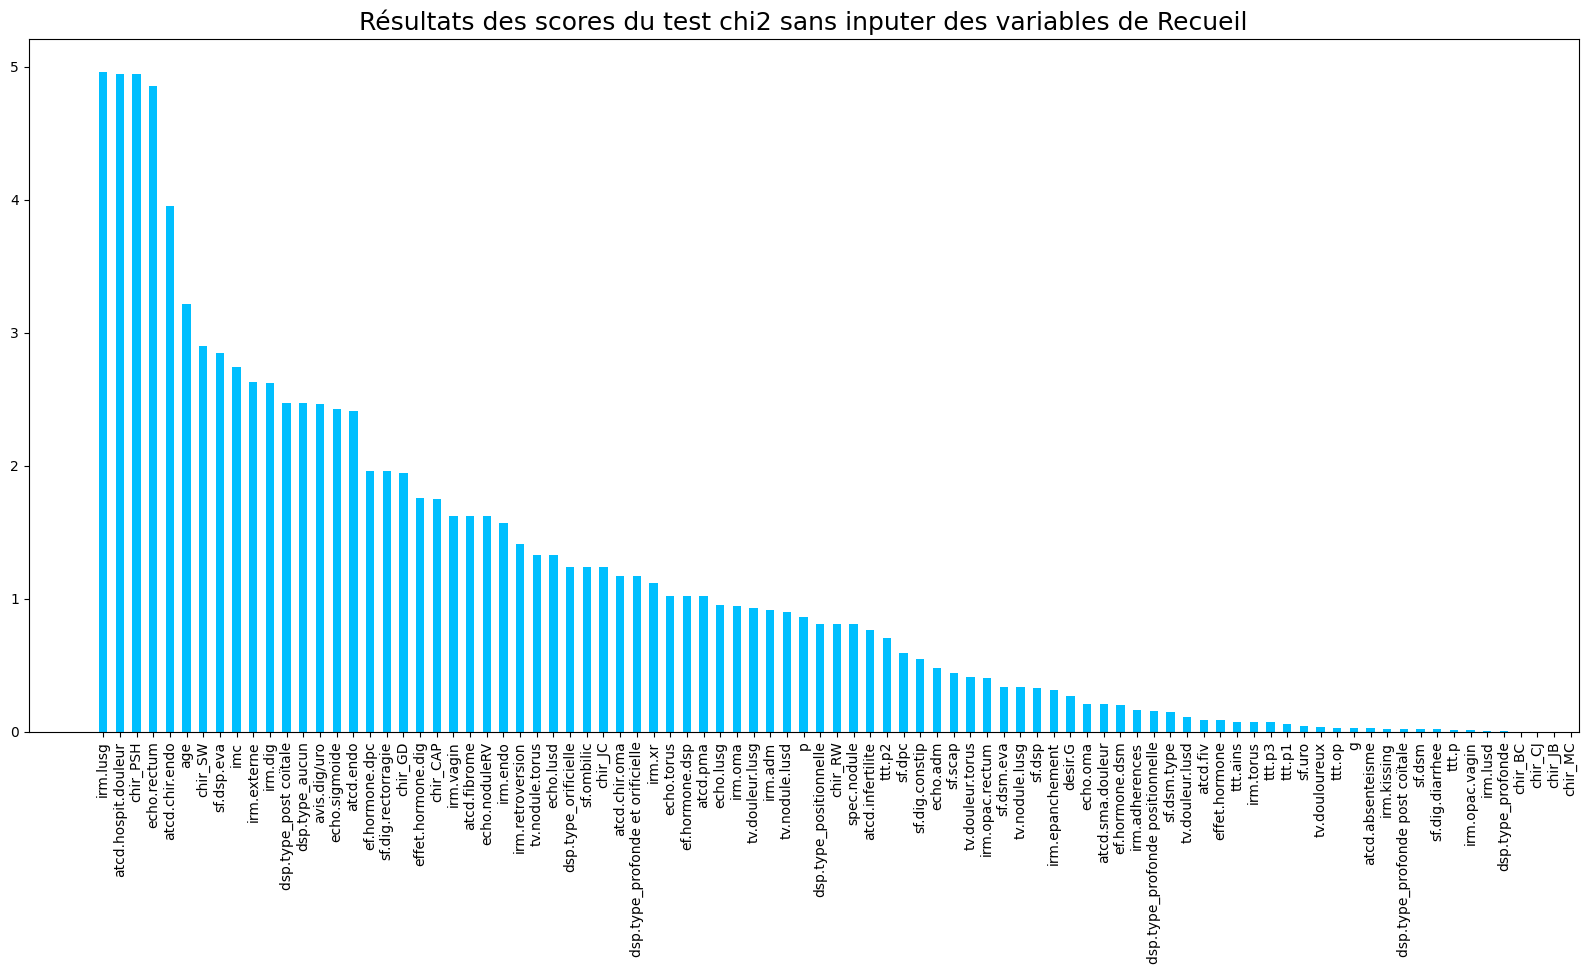

In [15]:
featureScores.sort_values('Score', inplace=True, ascending=False)


fig, ax = plt.subplots(1,1,figsize=(20, 9))


ax.set_title('Résultats des scores du test chi2 sans inputer des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)



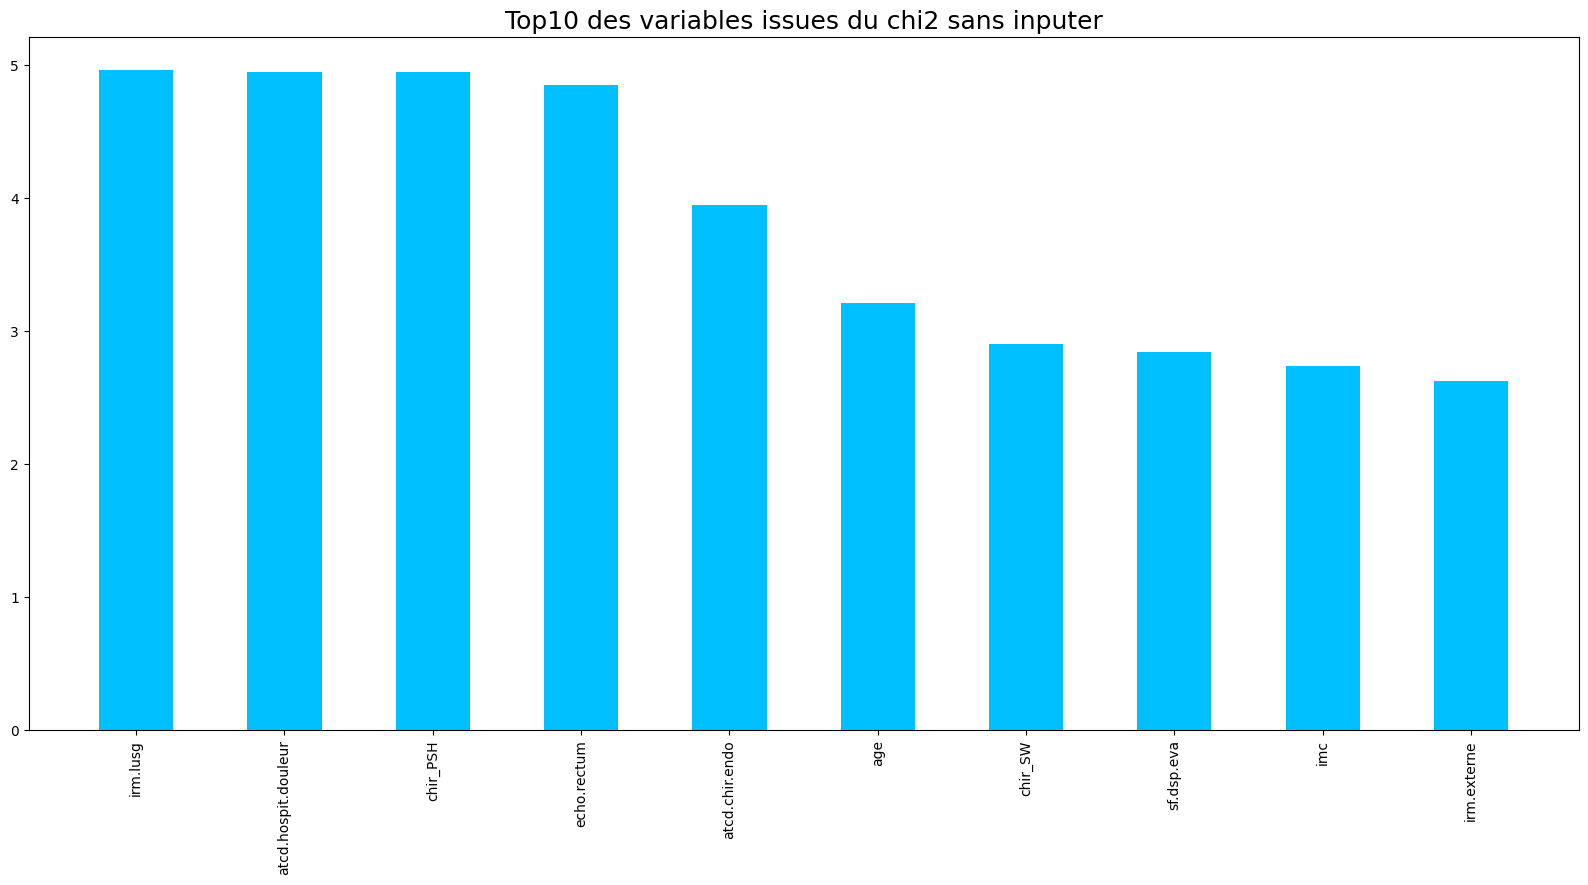

In [16]:

fig, ax = plt.subplots(1,1,figsize=(20, 9))


ax.set_title('Top10 des variables issues du chi2 sans inputer', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)



### f_classif test : 

In [17]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_f_drop = SelectKBest(score_func=f_classif, k=20)
fit_f_drop = bestfeatures_f_drop.fit(features_enc_dropna,endometriose_dropna)
dfscores_f_drop = pd.DataFrame(fit_f_drop.scores_)
pvalues_f_drop = pd.DataFrame(fit_f_drop.pvalues_)
dfcolumns_f_drop = pd.DataFrame(features_enc_dropna.columns)
#concat two dataframes for better visualization 
featureScores_f_drop = pd.concat([dfcolumns_f_drop,dfscores_f_drop,pvalues_f_drop],axis=1)
featureScores_f_drop.columns = ['Features','Score','p values']  #naming the dataframe columns
featureScores_f_drop.nlargest(10, 'Score')

/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [71 73 75 77 80] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/nounou/.cache/pypoetry/virtualenvs/endopaths-SLKnt0t7-py3.10/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Features,Score,p values
57,irm.lusg,8.071024,0.005657
7,atcd.chir.endo,6.420795,0.013159
54,irm.endo,5.556693,0.020764
52,echo.rectum,5.430129,0.022220
13,atcd.hospit.douleur,5.399308,0.022591
78,chir_PSH,5.399308,0.022591
4,atcd.endo,4.698216,0.033059
81,chir_SW,4.453623,0.037838
69,irm.externe,4.159206,0.044590
68,irm.xr,3.098166,0.082065


In [18]:
featureScores_f_drop.reset_index(drop=True, inplace=True)
featureScores_f_drop.to_excel('Data/f_test.xlsx')

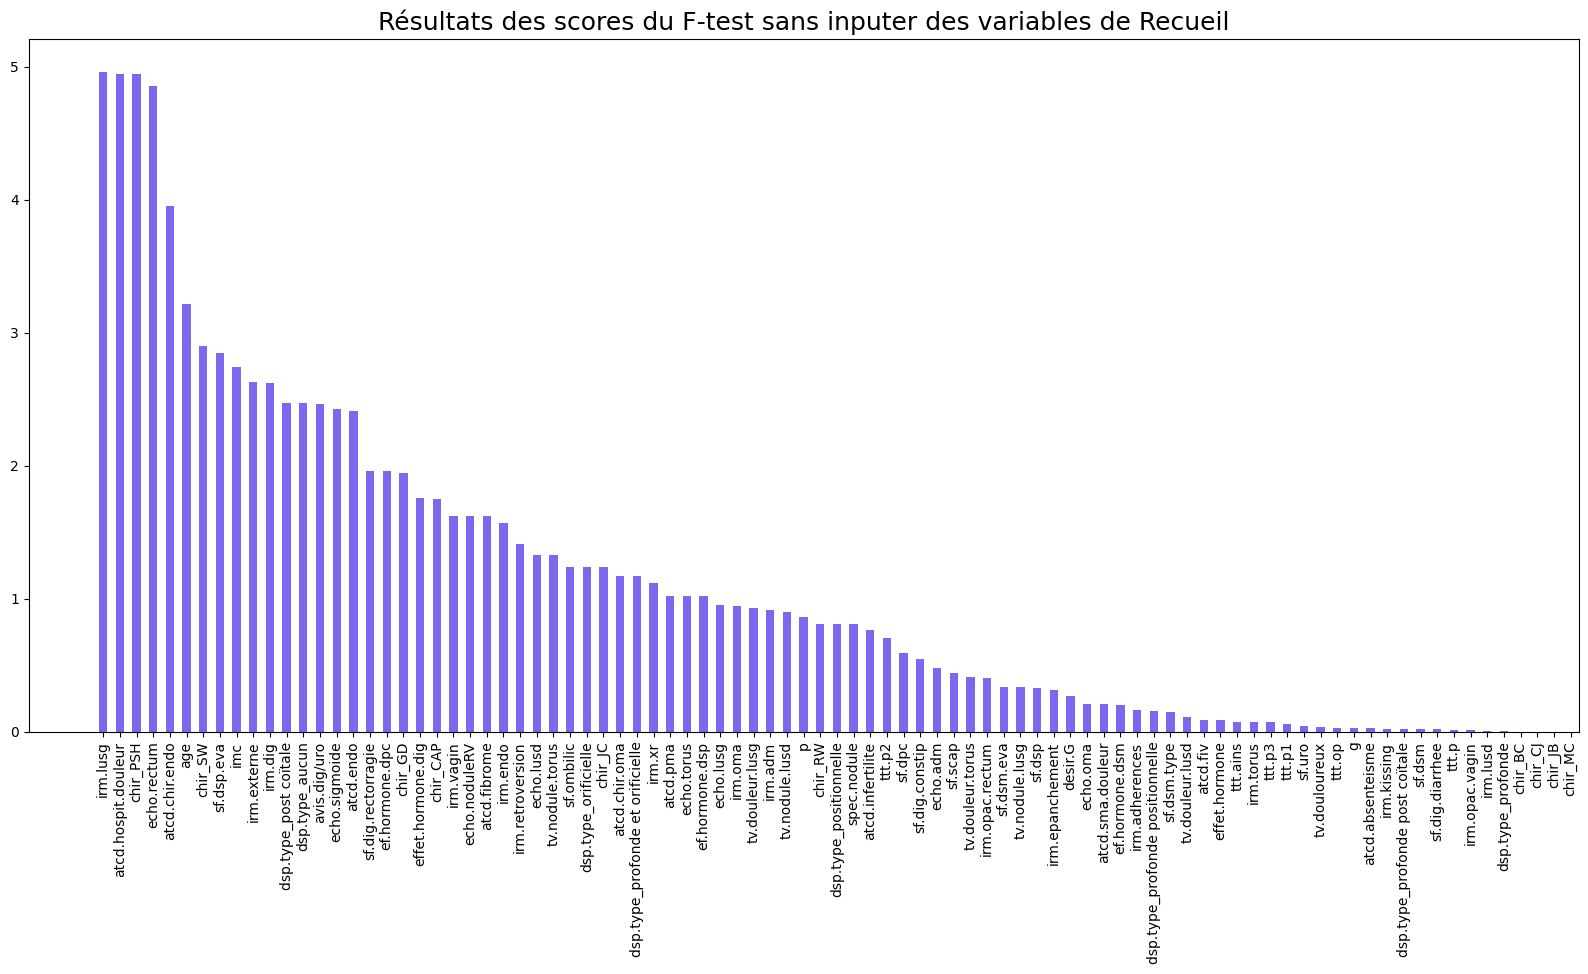

In [19]:
featureScores.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du F-test sans inputer des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)


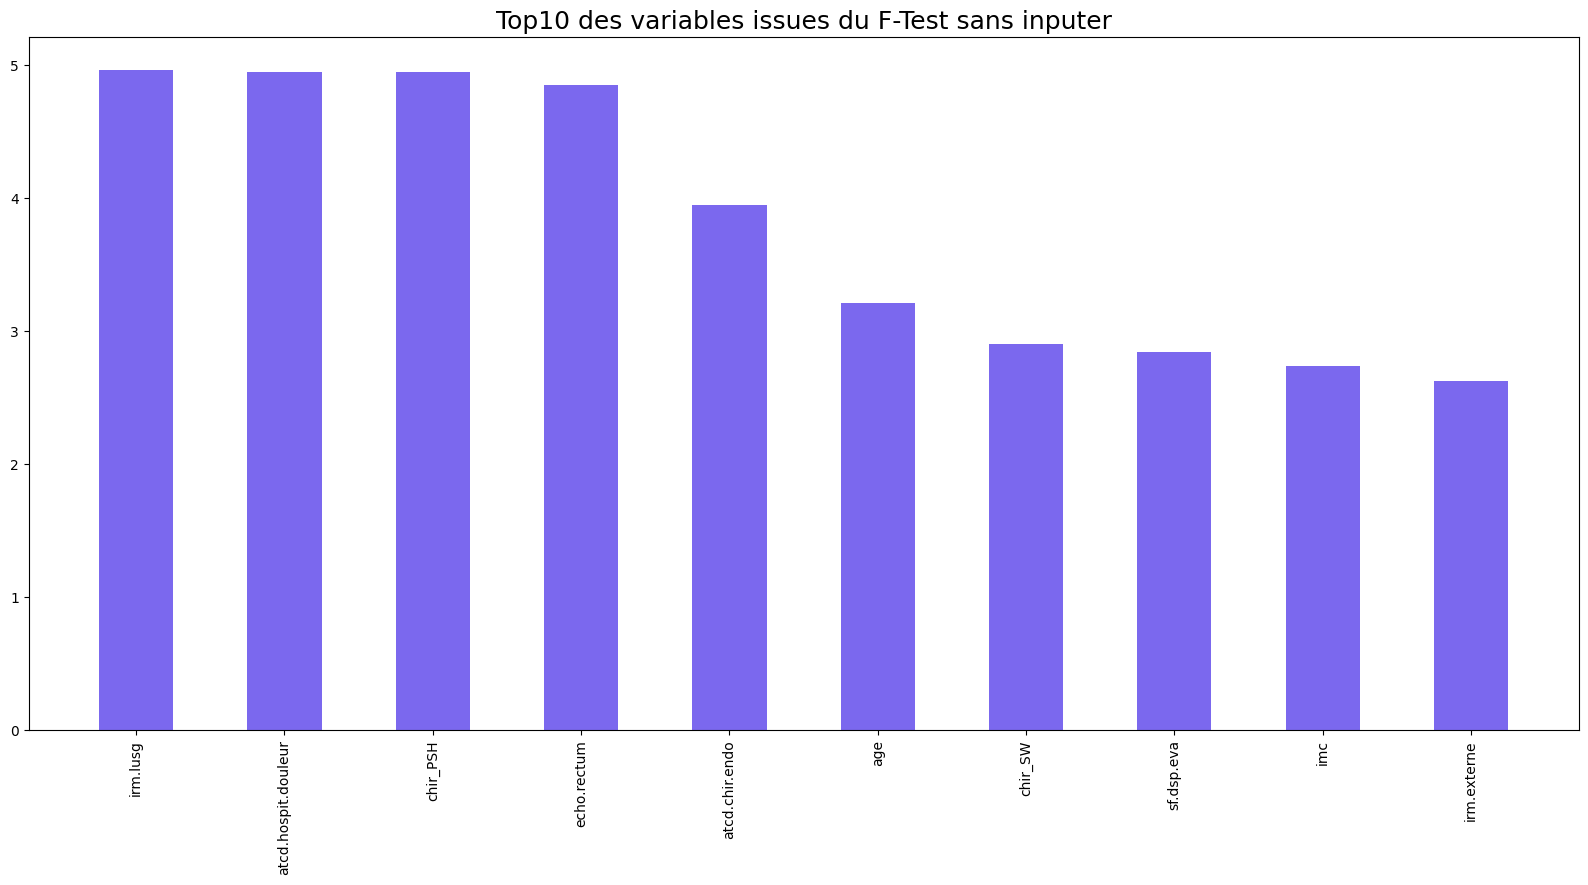

In [20]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))

ax.set_title('Top10 des variables issues du F-Test sans inputer', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

### mutual_info_classif test : 

In [21]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=20)
fit = bestfeatures.fit(features_enc_dropna,endometriose_dropna)
dfscores = pd.DataFrame(fit.scores_)
pvalues = pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(features_enc_dropna.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 20 best features

          Features     Score
36  ef.hormone.dpc  0.119540
57        irm.lusg  0.116623
69     irm.externe  0.092092
28  sf.dig.constip  0.086561
32      sf.ombilic  0.084232
7   atcd.chir.endo  0.074937
45     spec.nodule  0.068505
35  ef.hormone.dsm  0.062746
60         irm.dig  0.058907
19          ttt.p2  0.054504


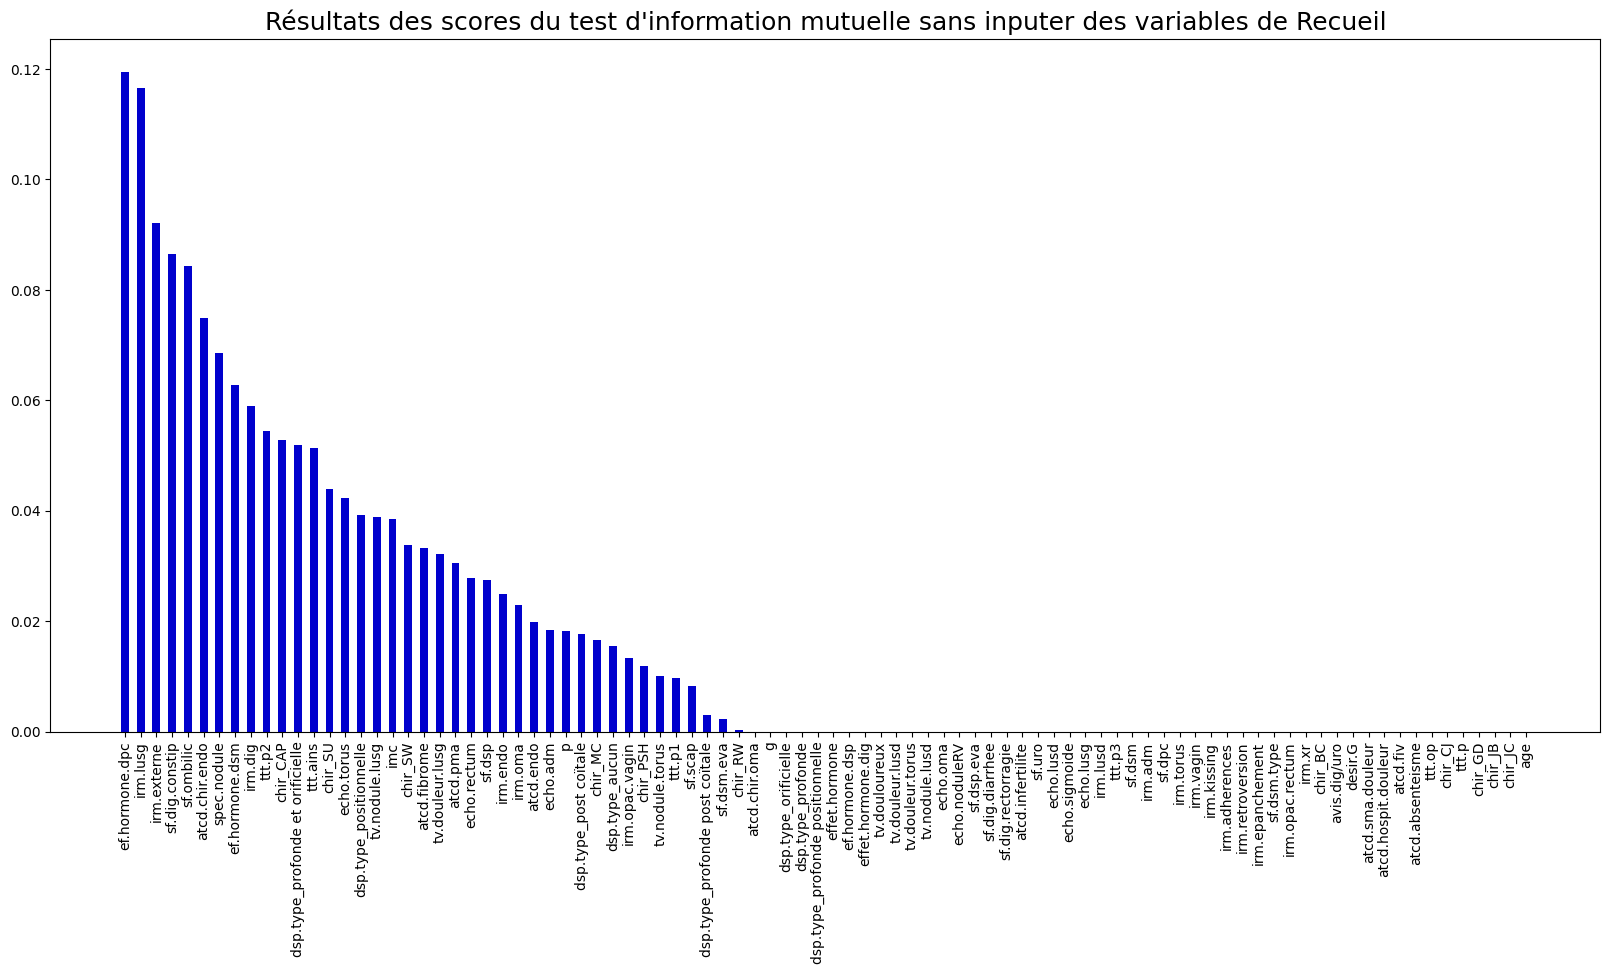

In [22]:
featureScores.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du test d\'information mutuelle sans inputer des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

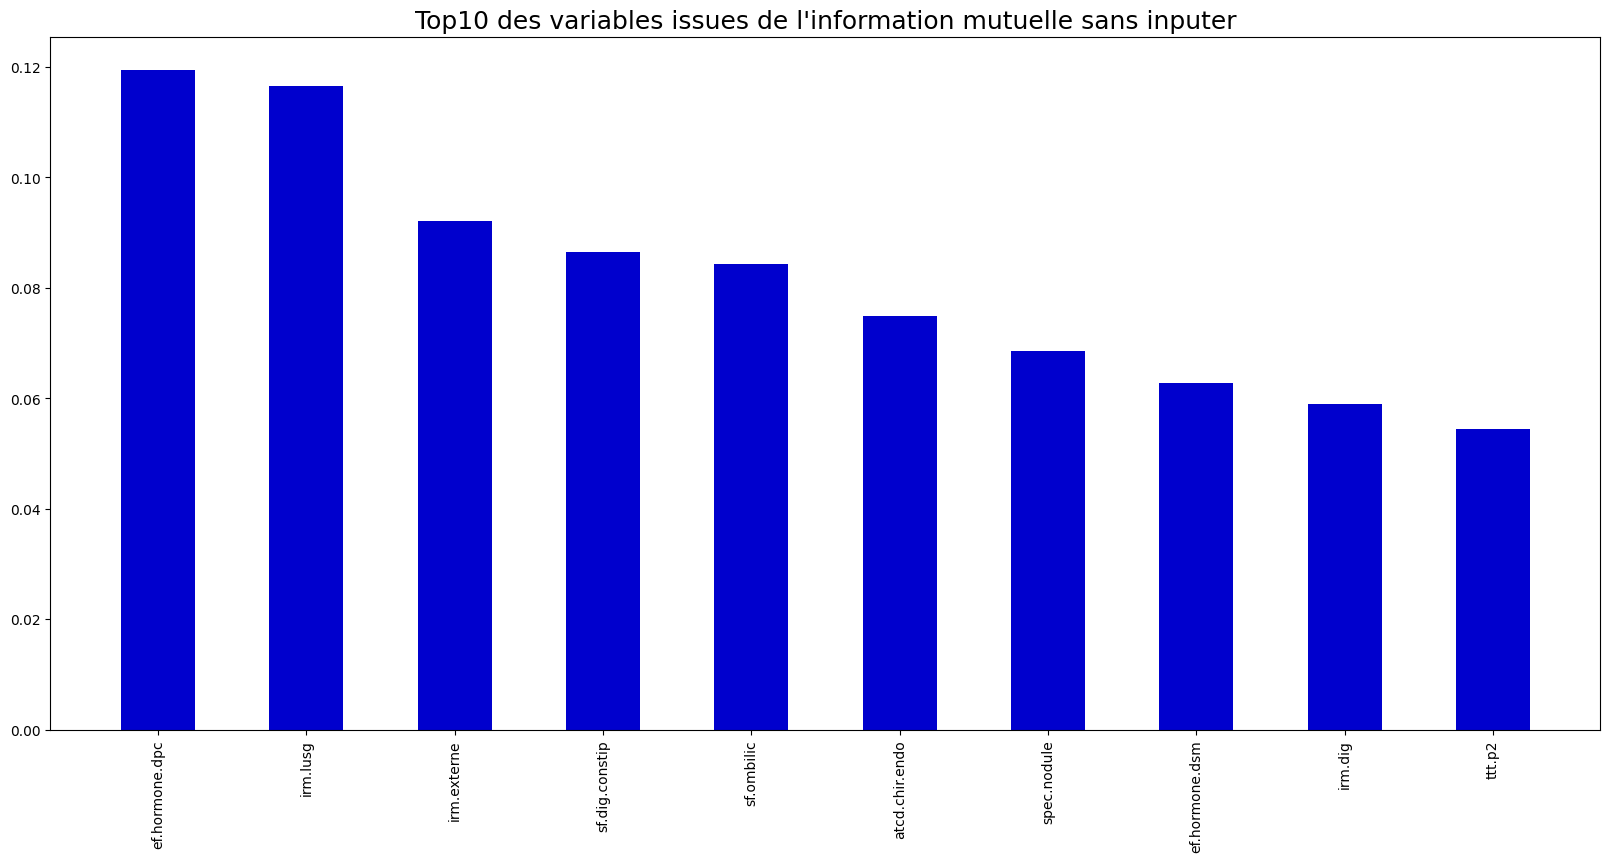

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))

ax.set_title('Top10 des variables issues de l\'information mutuelle sans inputer', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

# Avec imputer

## préparation des données : 

In [24]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')

features_enc_mean = imp_mean.fit_transform(features_enc)
features_enc_mode = imp_mode.fit_transform(features_enc)
features_enc_median = imp_median.fit_transform(features_enc)

features_enc_mean = pd.DataFrame(features_enc_mean, columns=imp_mean.get_feature_names_out())
features_enc_mode = pd.DataFrame(features_enc_mode, columns=imp_mode.get_feature_names_out())
features_enc_median = pd.DataFrame(features_enc_median, columns=imp_median.get_feature_names_out())

## Etude mean :

### Chi2 test : 

In [25]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_chi_mean = SelectKBest(score_func=chi2, k=20)
fit_chi_mean = bestfeatures_chi_mean.fit(features_enc_mean,endometriose)
dfscores_chi_mean = pd.DataFrame(fit_chi_mean.scores_)
pvalues_chi_mean = pd.DataFrame(fit_chi_mean.pvalues_)
dfcolumns_chi_mean = pd.DataFrame(features_enc_mean.columns)
#concat two dataframes for better visualization 
featureScores_chi_mean = pd.concat([dfcolumns_chi_mean,dfscores_chi_mean,pvalues_chi_mean],axis=1)
featureScores_chi_mean.columns = ['Features','Score','p value']  #naming the dataframe columns
print(featureScores_chi_mean.nlargest(10,'Score'))  #print 20 best features

          Features     Score   p value
0              age  8.755466  0.003087
7   atcd.chir.endo  7.707551  0.005499
26      sf.dsp.eva  5.919248  0.014976
57        irm.lusg  5.512239  0.018884
4        atcd.endo  5.154469  0.023187
60         irm.dig  4.960777  0.025929
52     echo.rectum  4.120304  0.042371
70    avis.dig/uro  3.969303  0.046337
53   echo.sigmoide  3.733193  0.053341
78        chir_PSH  3.523704  0.060497


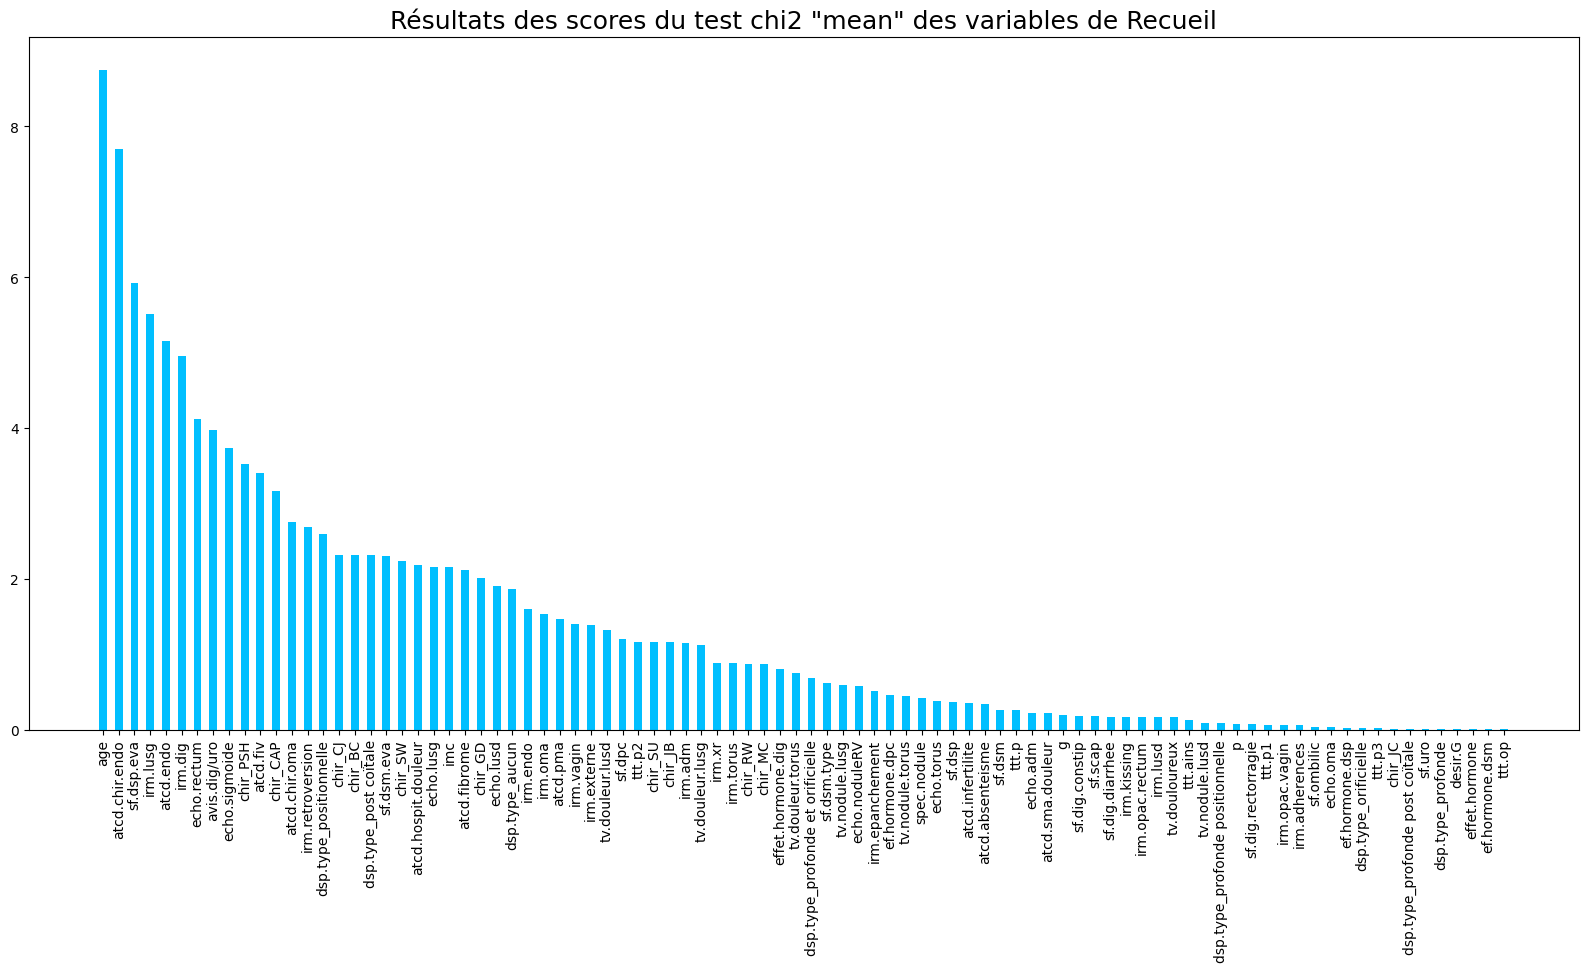

In [26]:
featureScores_chi_mean.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du test chi2 "mean" des variables de Recueil', fontsize=18)
ax.bar(featureScores_chi_mean['Features'], height=featureScores_chi_mean['Score'], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

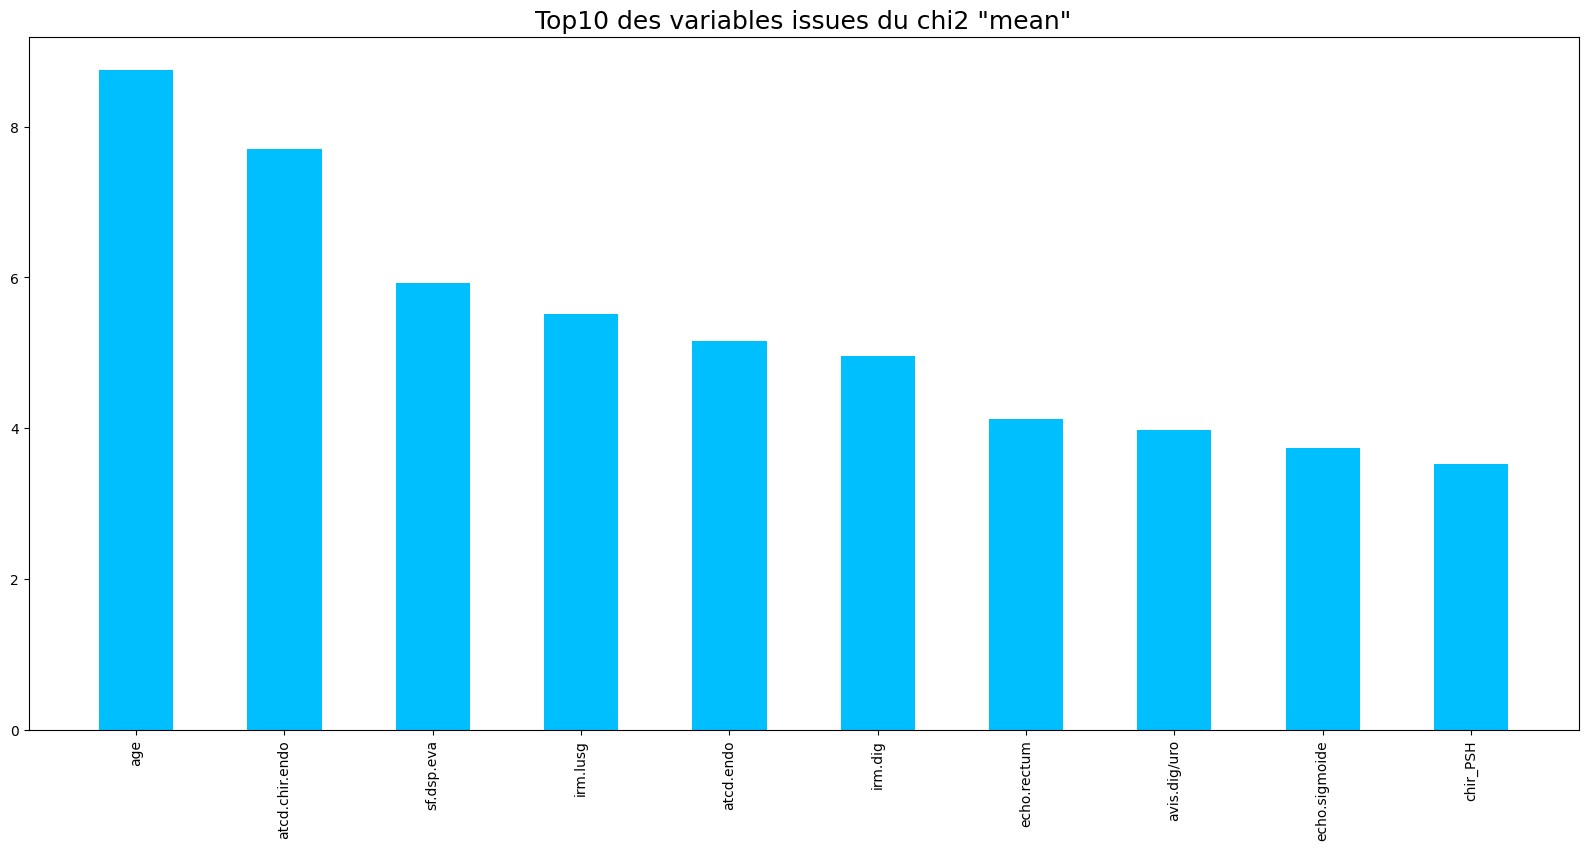

In [27]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues du chi2 "mean"', fontsize=18)
ax.bar(featureScores_chi_mean['Features'].iloc[:10], height=featureScores_chi_mean['Score'].iloc[:10], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

### f_classif test : 

In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_f_mean = SelectKBest(score_func=f_classif, k=20)
fit_f_mean = bestfeatures_f_mean.fit(features_enc_mean, endometriose)
pvalues_f_mean = pd.DataFrame(fit_f_mean.pvalues_)
dfscores_f_mean = pd.DataFrame(fit_f_mean.scores_)
dfcolumns_f_mean = pd.DataFrame(features_enc_mean.columns)
#concat two dataframes for better visualization 
featureScores_f_mean = pd.concat([dfcolumns_f_mean,dfscores_f_mean,pvalues_f_mean],axis=1)
featureScores_f_mean.columns = ['Features','Score','p value']  #naming the dataframe columns
print(featureScores_f_mean.nlargest(10,'Score'))  #print 20 best features

          Features      Score   p value
7   atcd.chir.endo  11.863638  0.000713
4        atcd.endo   9.626426  0.002229
57        irm.lusg   8.398243  0.004225
0              age   6.477023  0.011772
54        irm.endo   6.063025  0.014751
60         irm.dig   5.764629  0.017376
52     echo.rectum   5.090667  0.025265
21          sf.dsm   4.878554  0.028462
70    avis.dig/uro   4.704377  0.031405
53   echo.sigmoide   4.476826  0.035740


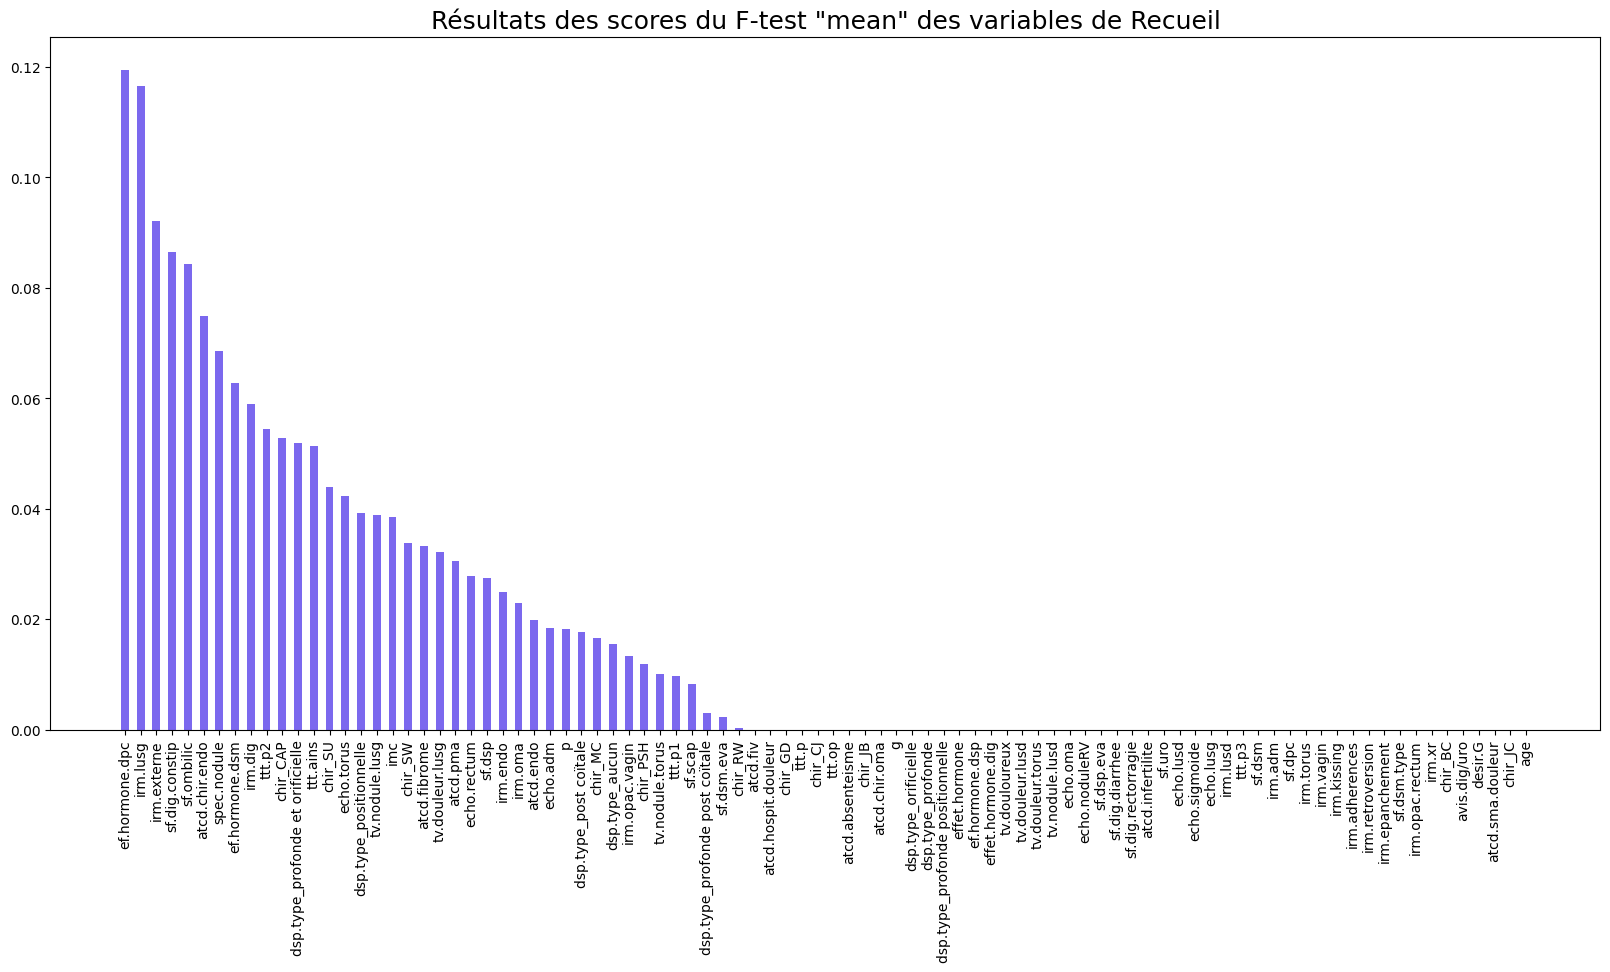

In [29]:
featureScores.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du F-test "mean" des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

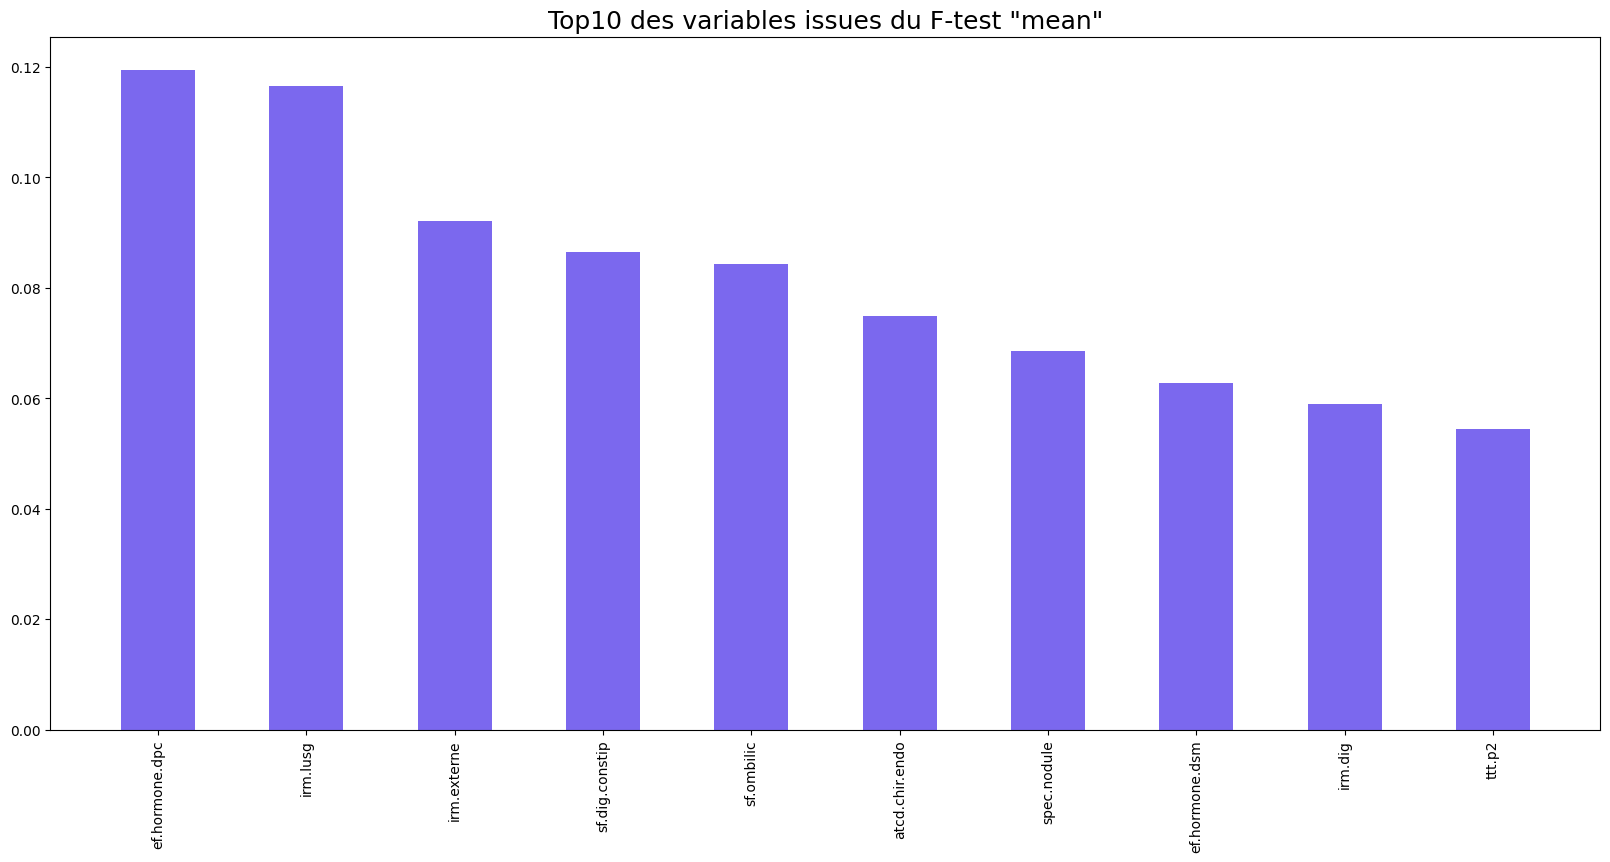

In [30]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues du F-test "mean"', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

In [61]:
df_p_values_f_mean = pd.DataFrame(fit.pvalues_, index=features_enc_mean.columns, columns=['p_value']) #TODO a voir
df_p_values_f_mean.sort_values('p_value', inplace=True)
df_p_values_f_mean.head(4)
#df_p_values_f_mean.loc[df_p_values_f_mean.loc[:,'p_value']<=0.05]

,p_value
age,NaN
imc,NaN
g,NaN
p,NaN


### mutual_info_classif test : 

In [32]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_mut = SelectKBest(score_func=mutual_info_classif, k=20)
fit_mut_mean = bestfeatures_mut.fit(features_enc_mean, endometriose)
dfscores_mut_mean = pd.DataFrame(fit_mut_mean.scores_)
dfcolumns_mut_mean = pd.DataFrame(features_enc_mean.columns)
#concat two dataframes for better visualization 
featureScores_mut_mean = pd.concat([dfcolumns_mut_mean,dfscores_mut_mean],axis=1)
featureScores_mut_mean.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores_mut_mean.nlargest(20,'Score'))  #print 20 best features

                          Features     Score
25                          sf.dsp  0.135181
8                 atcd.infertilite  0.083650
78                        chir_PSH  0.078756
80                         chir_SU  0.066771
15                          ttt.op  0.061843
67                 irm.opac.rectum  0.061309
49                       echo.lusd  0.058818
42                  tv.nodule.lusd  0.055352
0                              age  0.054496
14                atcd.absenteisme  0.050669
82                  dsp.type_aucun  0.047612
38                   tv.douloureux  0.043055
5                    atcd.chir.oma  0.041143
68                          irm.xr  0.040797
74                         chir_GD  0.039277
53                   echo.sigmoide  0.036405
89  dsp.type_profonde post coïtale  0.034344
21                          sf.dsm  0.032125
24                          sf.dpc  0.031385
77                         chir_MC  0.030472


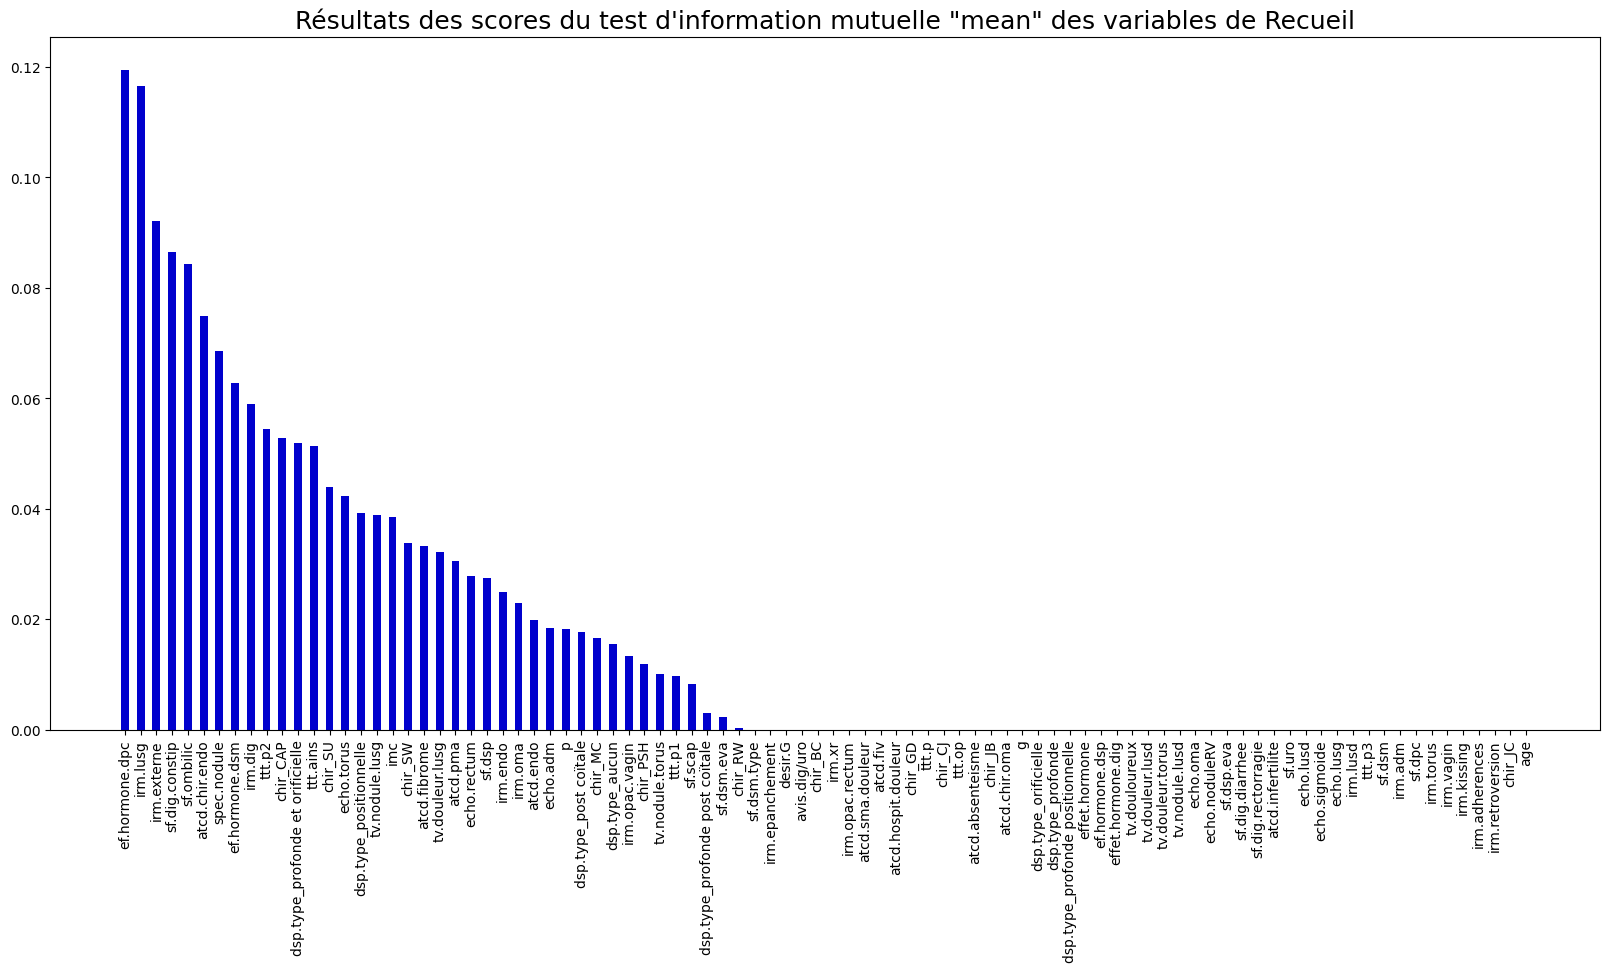

In [33]:
featureScores.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du test d\'information mutuelle "mean" des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

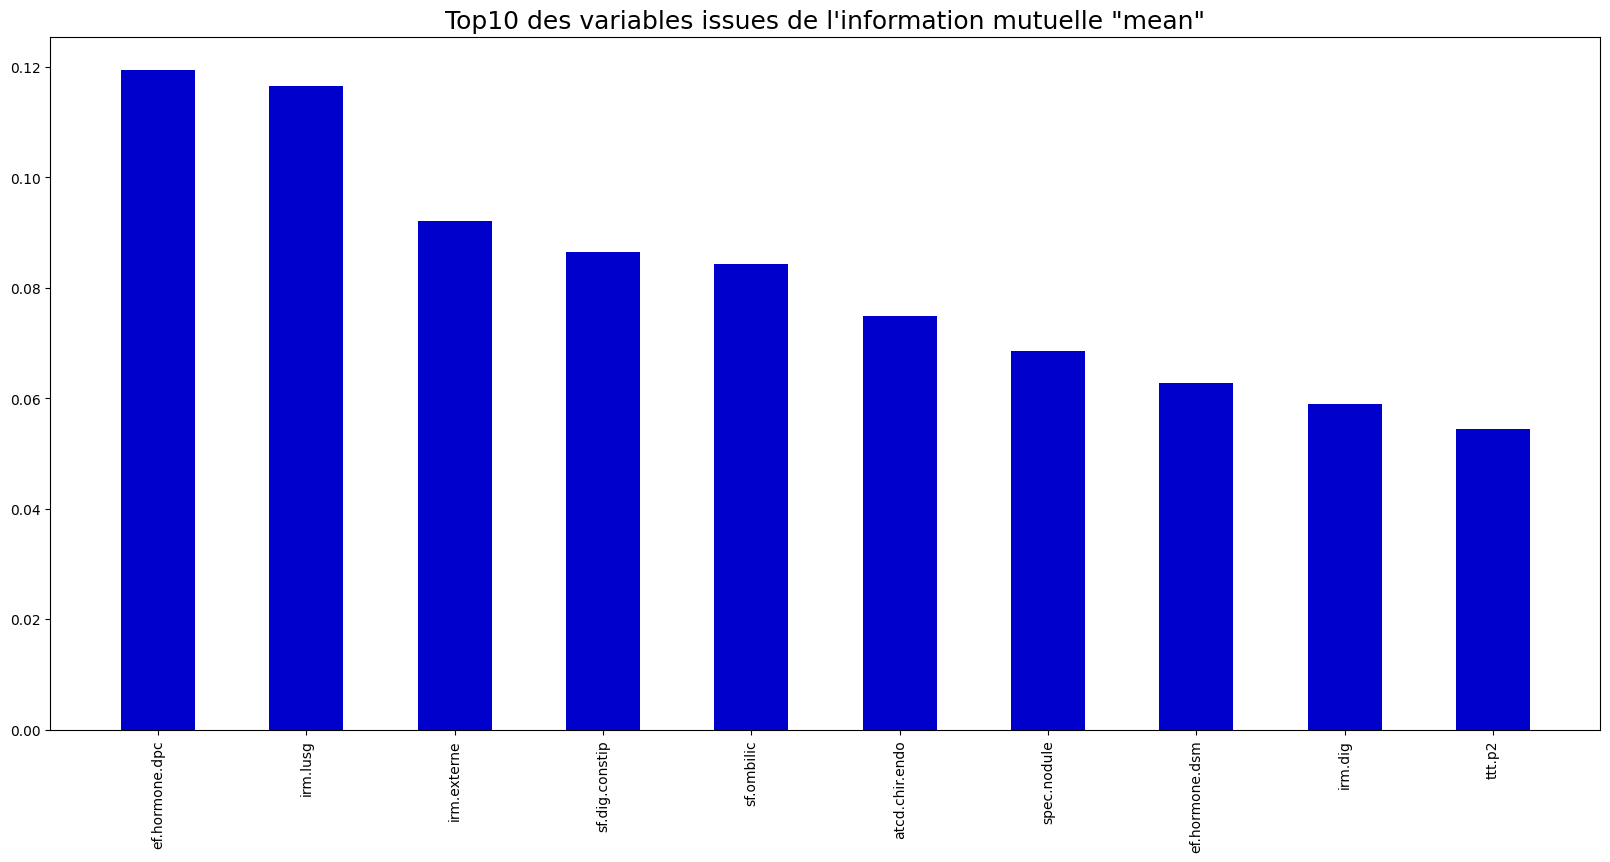

In [34]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues de l\'information mutuelle "mean"', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

## Etude mode :

### Chi2 test : 

In [35]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_chi_mode = SelectKBest(score_func=chi2, k=20)
fit_ch_mode = bestfeatures_chi_mode.fit(features_enc_mode,endometriose)
dfscores_chi_mode = pd.DataFrame(fit_ch_mode.scores_)
p_val_chi_mode = pd.DataFrame(fit_ch_mode.pvalues_)
dfcolumns_chi_mode = pd.DataFrame(features_enc_mode.columns)
#concat two dataframes for better visualization 
featureScores_chi_mode = pd.concat([dfcolumns_chi_mode,dfscores_chi_mode,p_val_chi_mode],axis=1)
featureScores_chi_mode.columns = ['Features','Score','p value']  #naming the dataframe columns
print(featureScores_chi_mode.nlargest(10,'Score'))  #print 20 best features

          Features     Score   p value
0              age  8.755466  0.003087
7   atcd.chir.endo  7.707551  0.005499
57        irm.lusg  5.512239  0.018884
4        atcd.endo  5.154469  0.023187
52     echo.rectum  5.030966  0.024898
60         irm.dig  4.960777  0.025929
53   echo.sigmoide  4.508605  0.033725
70    avis.dig/uro  3.969303  0.046337
78        chir_PSH  3.523704  0.060497
10        atcd.fiv  3.406426  0.064943


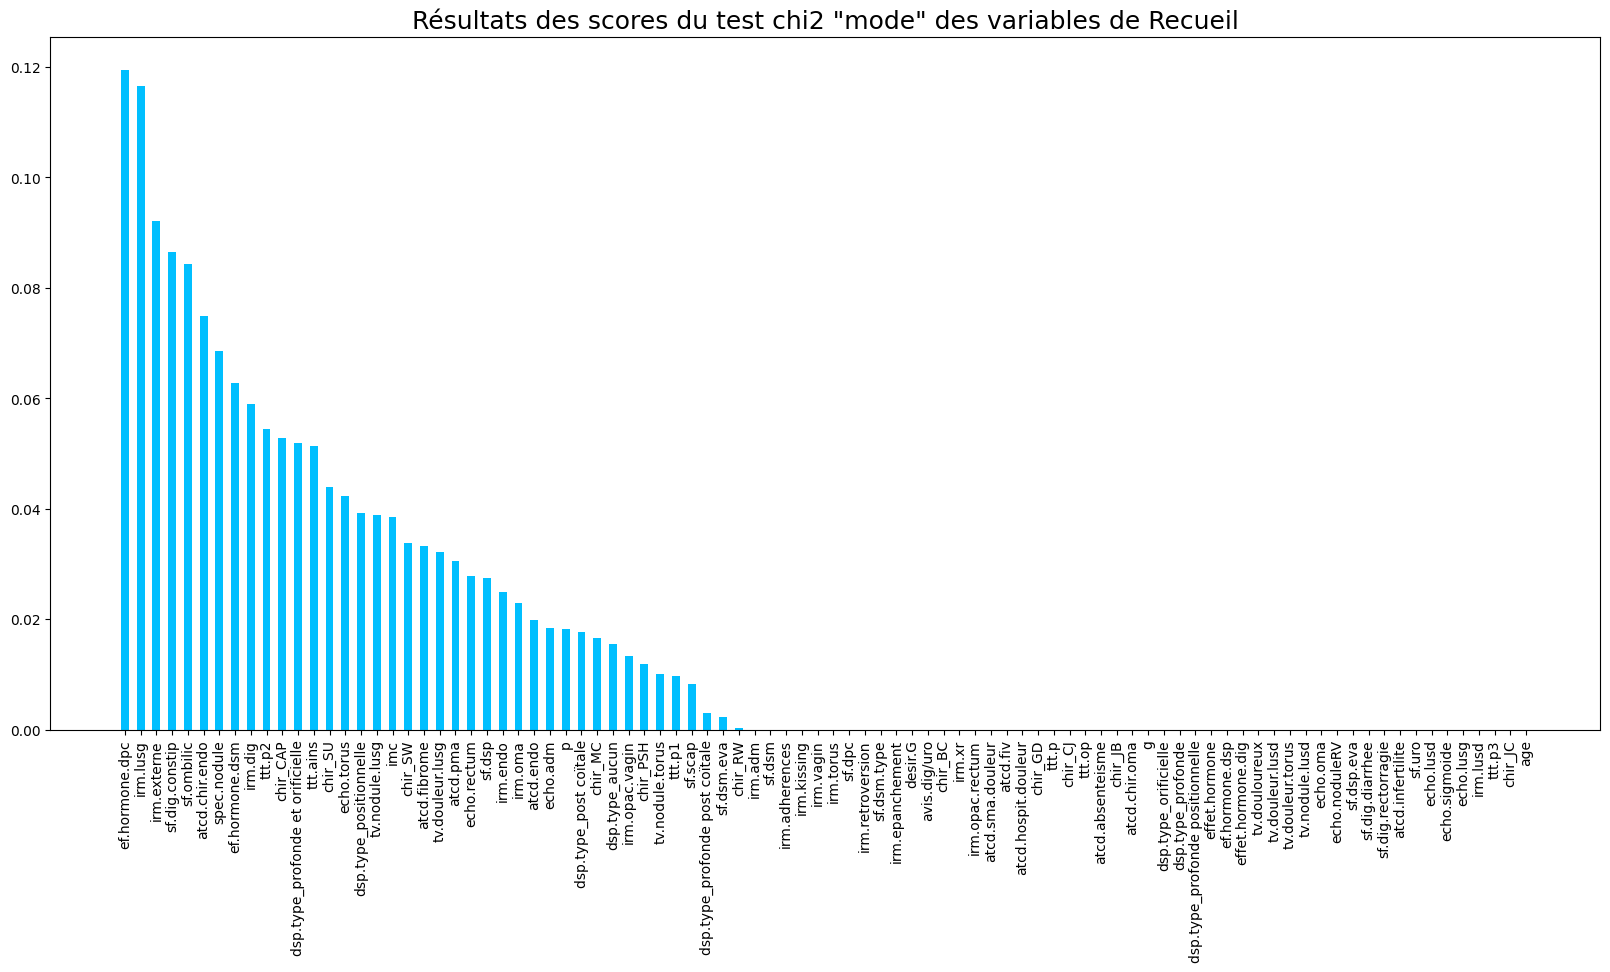

In [36]:
featureScores.sort_values('Score', inplace=True, ascending=False)


fig, ax = plt.subplots(1,1,figsize=(20, 9))


ax.set_title('Résultats des scores du test chi2 "mode" des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)



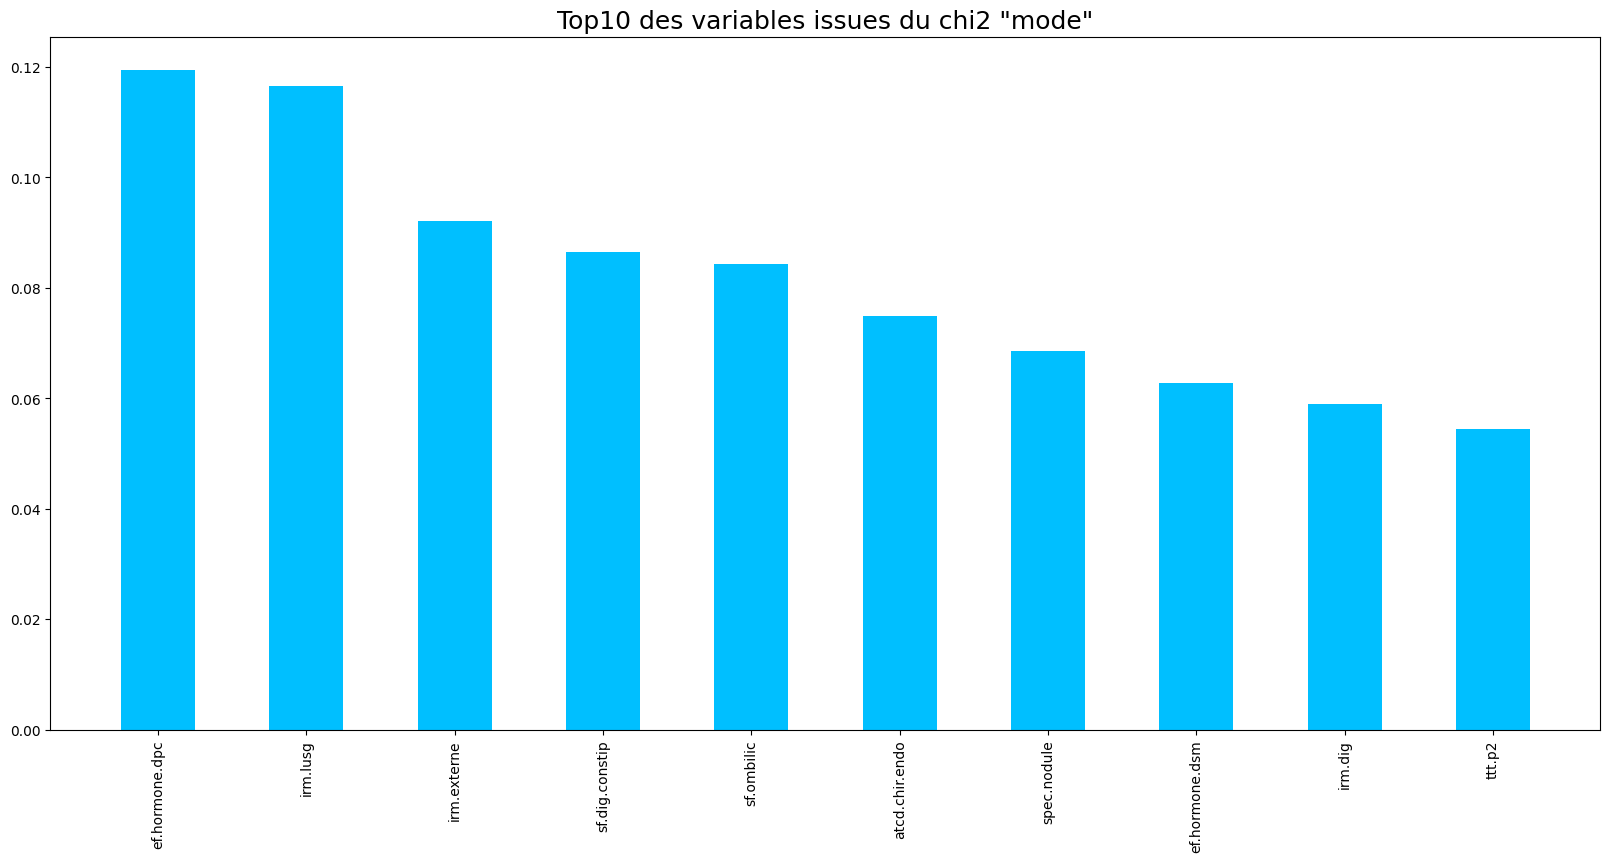

In [37]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues du chi2 "mode"', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

In [38]:
df_p_values_chi_mode = pd.DataFrame(fit.pvalues_, index=features_enc_mean.columns, columns=['p_value'])
df_p_values_chi_mode.sort_values('p_value', inplace=True)
df_p_values_chi_mode.loc[df_p_values_chi_mode.loc[:,'p_value']<=0.05]

,p_value


### f_classif test : 

In [39]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_f_mode = SelectKBest(score_func=f_classif, k=20)
fit_f_mode = bestfeatures_f_mode.fit(features_enc_mode, endometriose)
dfscores_f_mode = pd.DataFrame(fit_f_mode.scores_)
pval_f_mode = pd.DataFrame(fit_f_mode.pvalues_)
dfcolumns_f_mode = pd.DataFrame(features_enc_mode.columns)
#concat two dataframes for better visualization 
featureScores_f_mode = pd.concat([dfcolumns_f_mode,dfscores_f_mode, pval_f_mode],axis=1)
featureScores_f_mode.columns = ['Features','Score', 'p value']  #naming the dataframe columns
print(featureScores_f_mode.nlargest(10,'Score'))  #print 20 best features

          Features      Score   p value
7   atcd.chir.endo  11.863638  0.000713
4        atcd.endo   9.626426  0.002229
57        irm.lusg   8.398243  0.004225
0              age   6.477023  0.011772
54        irm.endo   6.063025  0.014751
60         irm.dig   5.764629  0.017376
52     echo.rectum   5.525852  0.019826
21          sf.dsm   4.878554  0.028462
53   echo.sigmoide   4.818398  0.029444
70    avis.dig/uro   4.704377  0.031405


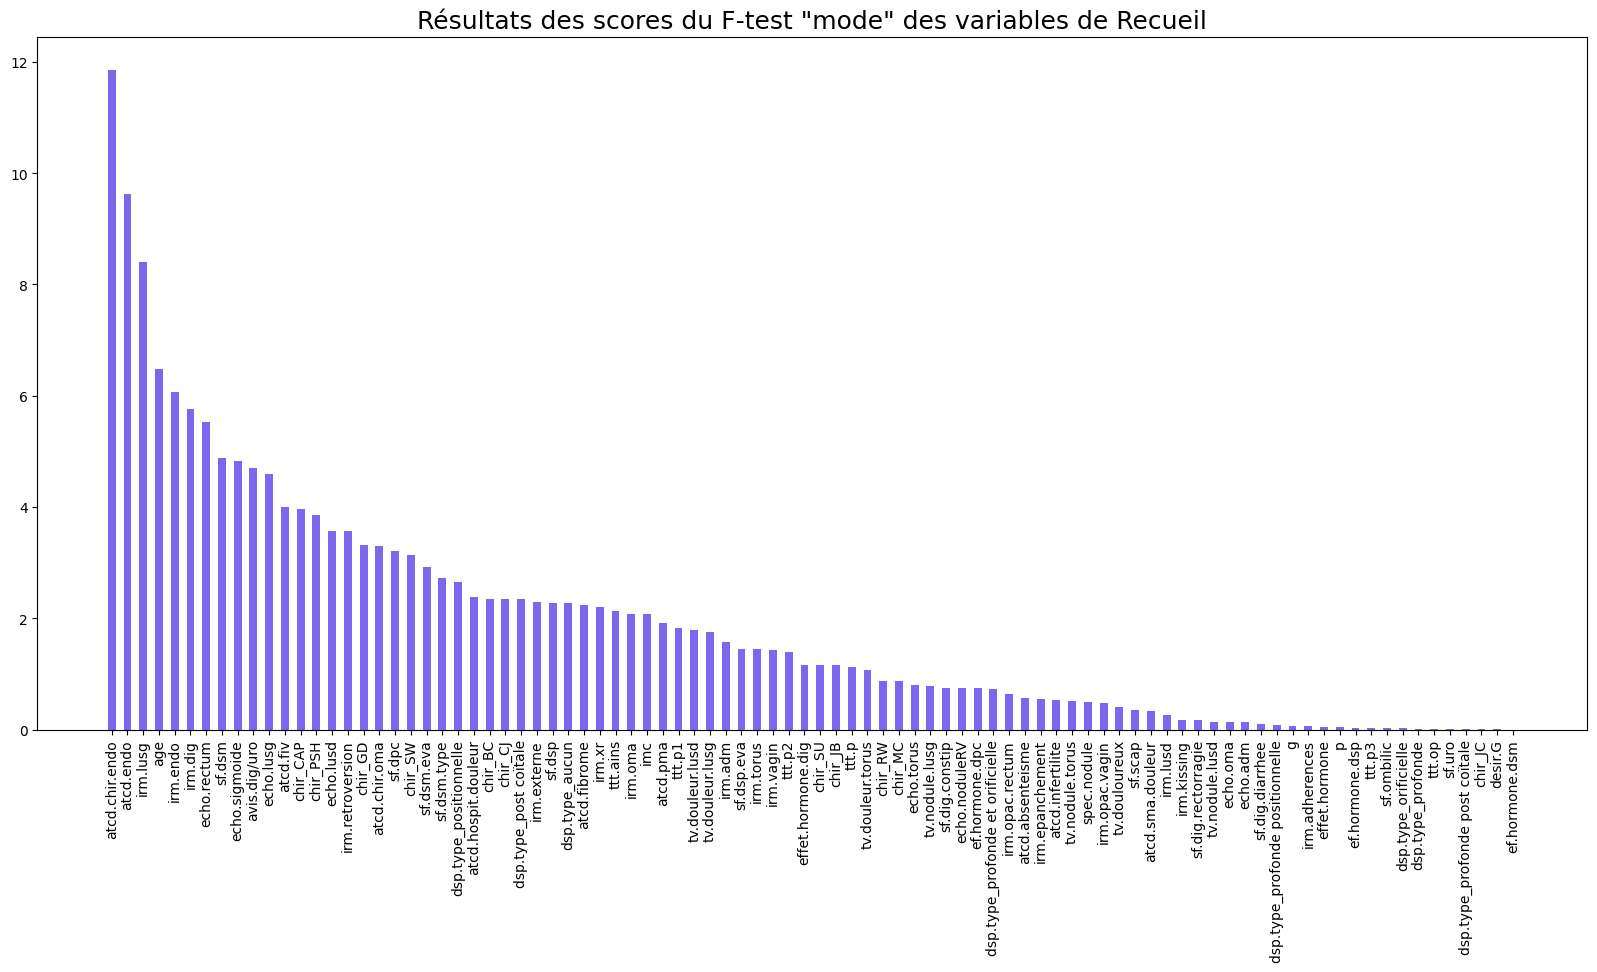

In [40]:
featureScores_f_mode.sort_values('Score', inplace=True, ascending=False)


fig, ax = plt.subplots(1,1,figsize=(20, 9))


ax.set_title('Résultats des scores du F-test "mode" des variables de Recueil', fontsize=18)
ax.bar(featureScores_f_mode['Features'], height=featureScores_f_mode['Score'], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)



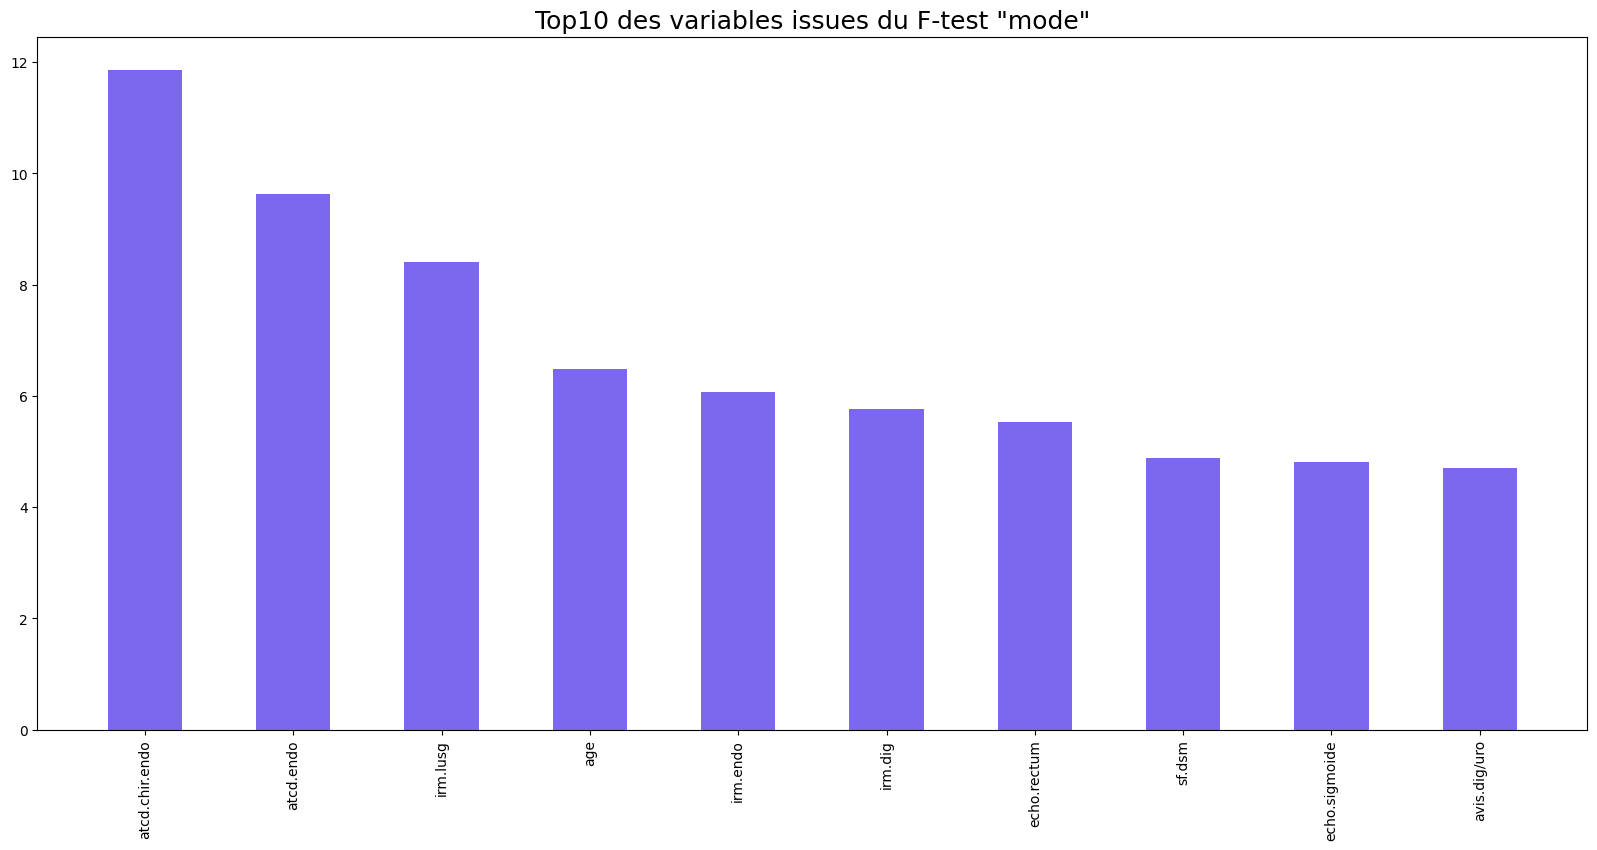

In [41]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues du F-test "mode"', fontsize=18)
ax.bar(featureScores_f_mode['Features'].iloc[:10], height=featureScores_f_mode['Score'].iloc[:10], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

### mutual_info_classif test : 

In [42]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=20)
fit = bestfeatures.fit(features_enc_mode, endometriose)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features_enc_mode.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

                            Features     Score
61                         irm.vagin  0.098793
19                            ttt.p2  0.075902
65                   irm.epanchement  0.066571
81                           chir_SW  0.065119
0                                age  0.063330
63                    irm.adherences  0.057143
30                            sf.uro  0.057130
64                  irm.retroversion  0.056592
59                           irm.oma  0.056364
4                          atcd.endo  0.049894
50                         echo.lusg  0.049555
12                  atcd.sma.douleur  0.048186
87  dsp.type_profonde et orificielle  0.043654
25                            sf.dsp  0.043578
57                          irm.lusg  0.040931
3                                  p  0.038670
10                          atcd.fiv  0.037871
17                          ttt.ains  0.035170
14                  atcd.absenteisme  0.034314
39                   tv.douleur.lusd  0.032857


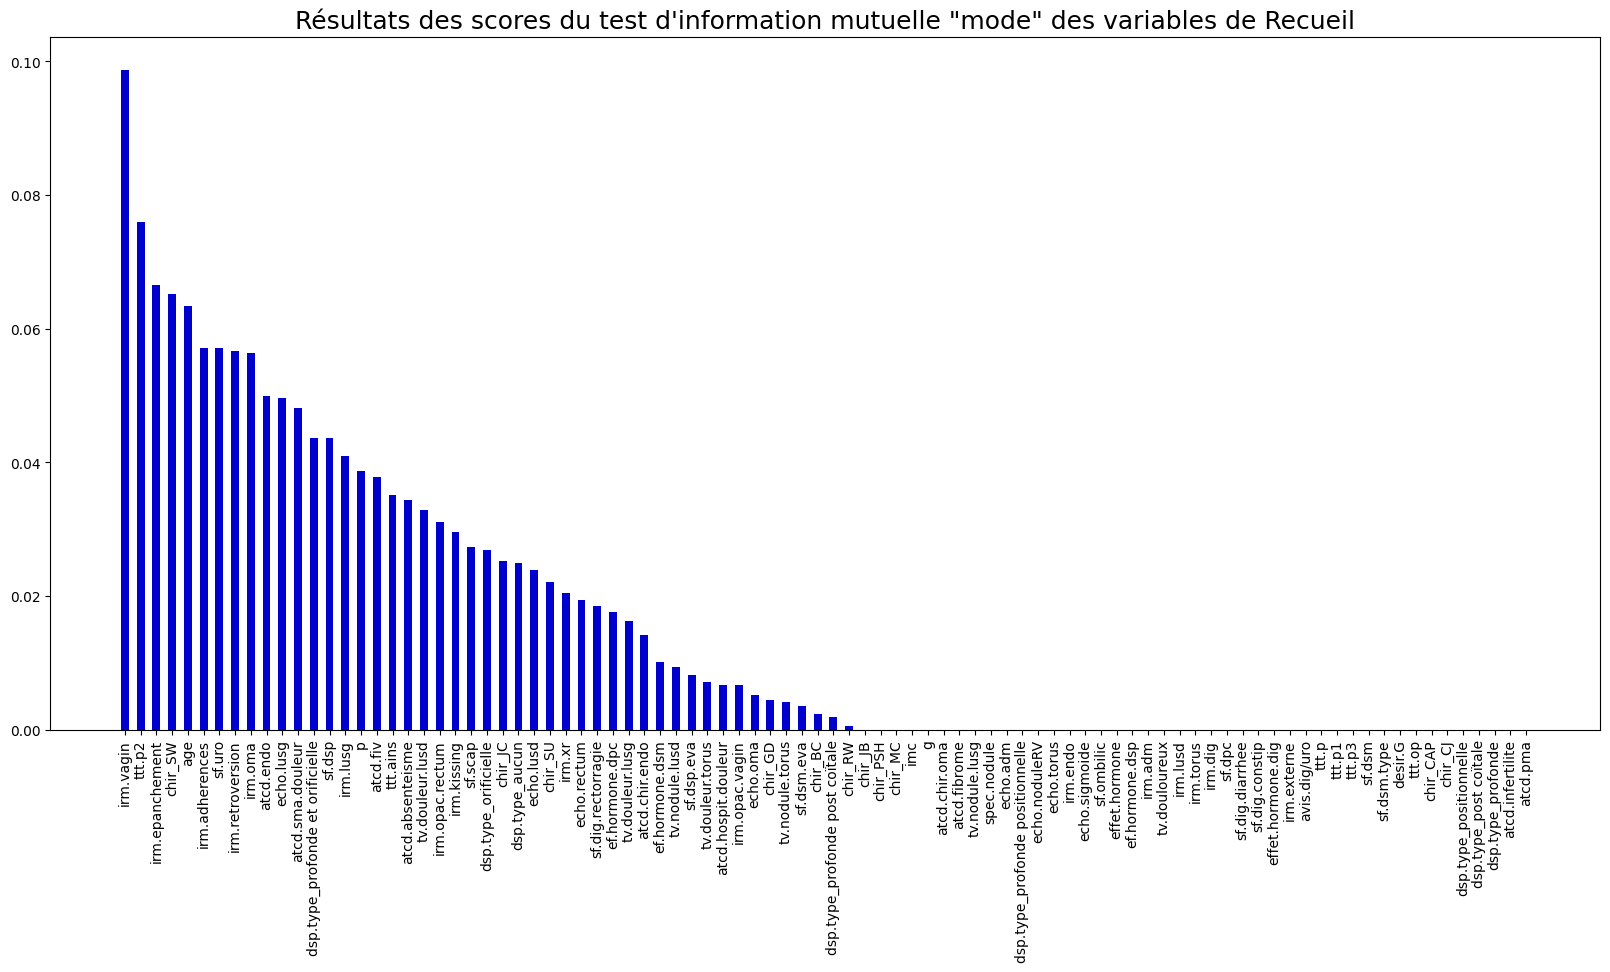

In [43]:
featureScores.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du test d\'information mutuelle "mode" des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

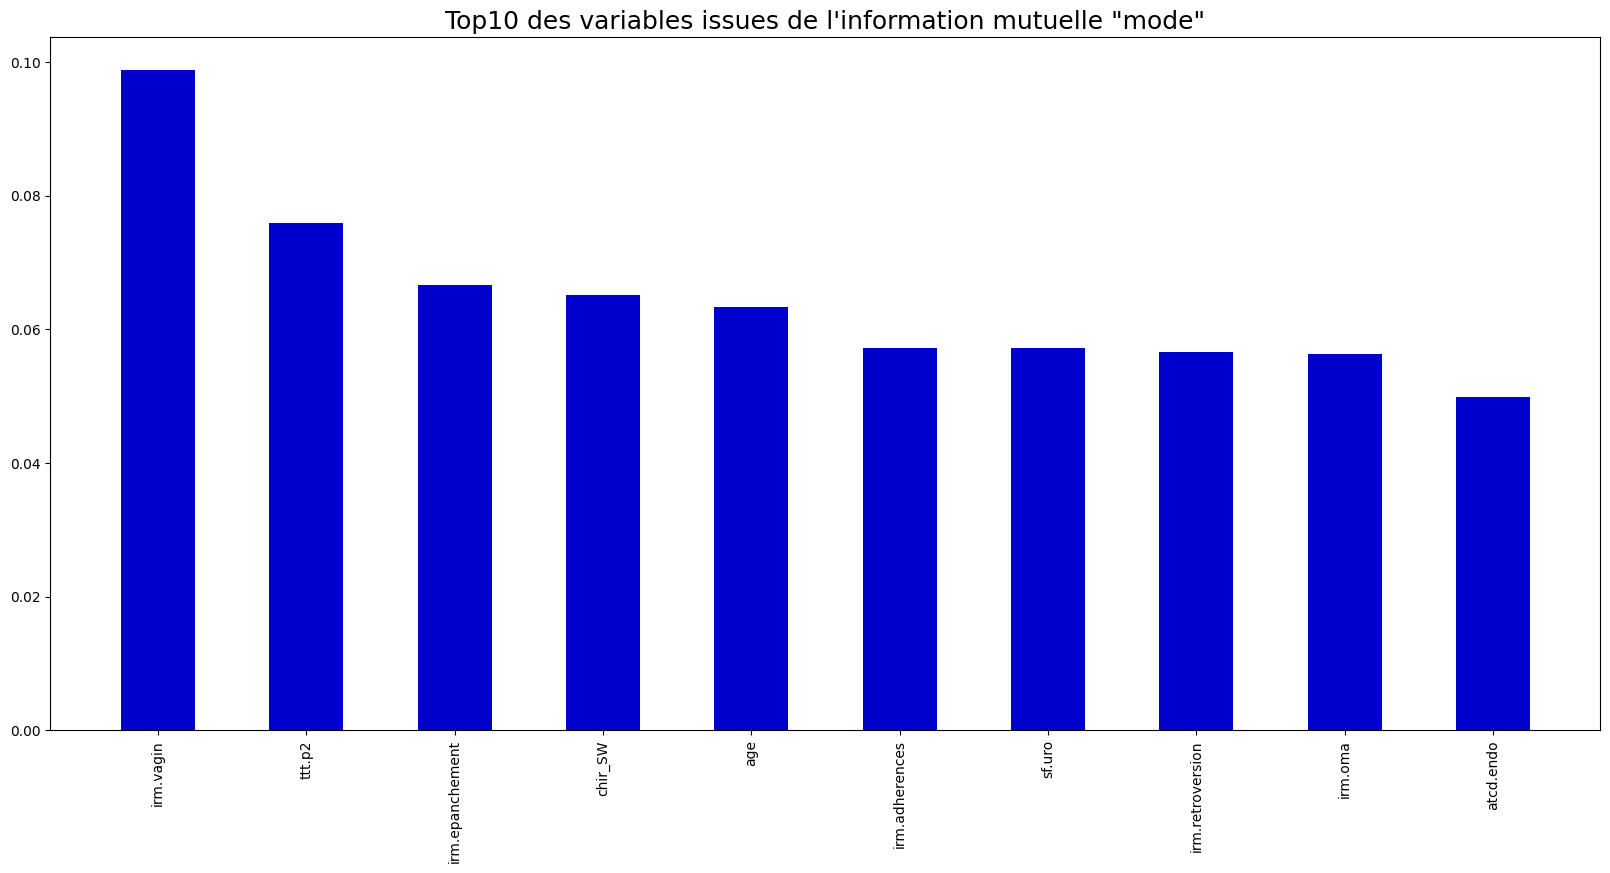

In [44]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues de l\'information mutuelle "mode"', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

## Etude median :

### Chi2 test : 

In [45]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_chi_med = SelectKBest(score_func=chi2, k=20)
fit_chi_med = bestfeatures_chi_med.fit(features_enc_median,endometriose)
pval_chi_med = pd.DataFrame(fit_chi_med.pvalues_)
dfscores_chi_med = pd.DataFrame(fit_chi_med.scores_)
dfcolumns_chi_med = pd.DataFrame(features_enc_median.columns)
#concat two dataframes for better visualization 
featureScores_chi_med = pd.concat([dfcolumns_chi_med,dfscores_chi_med, pval_chi_med],axis=1)
featureScores_chi_med.columns = ['Features','Score', 'p values']  #naming the dataframe columns
print(featureScores_chi_med.nlargest(10,'Score'))  #print 20 best features

          Features     Score  p values
0              age  8.755466  0.003087
7   atcd.chir.endo  7.707551  0.005499
26      sf.dsp.eva  6.219635  0.012634
57        irm.lusg  5.512239  0.018884
4        atcd.endo  5.154469  0.023187
52     echo.rectum  5.030966  0.024898
60         irm.dig  4.960777  0.025929
53   echo.sigmoide  4.508605  0.033725
70    avis.dig/uro  3.969303  0.046337
78        chir_PSH  3.523704  0.060497


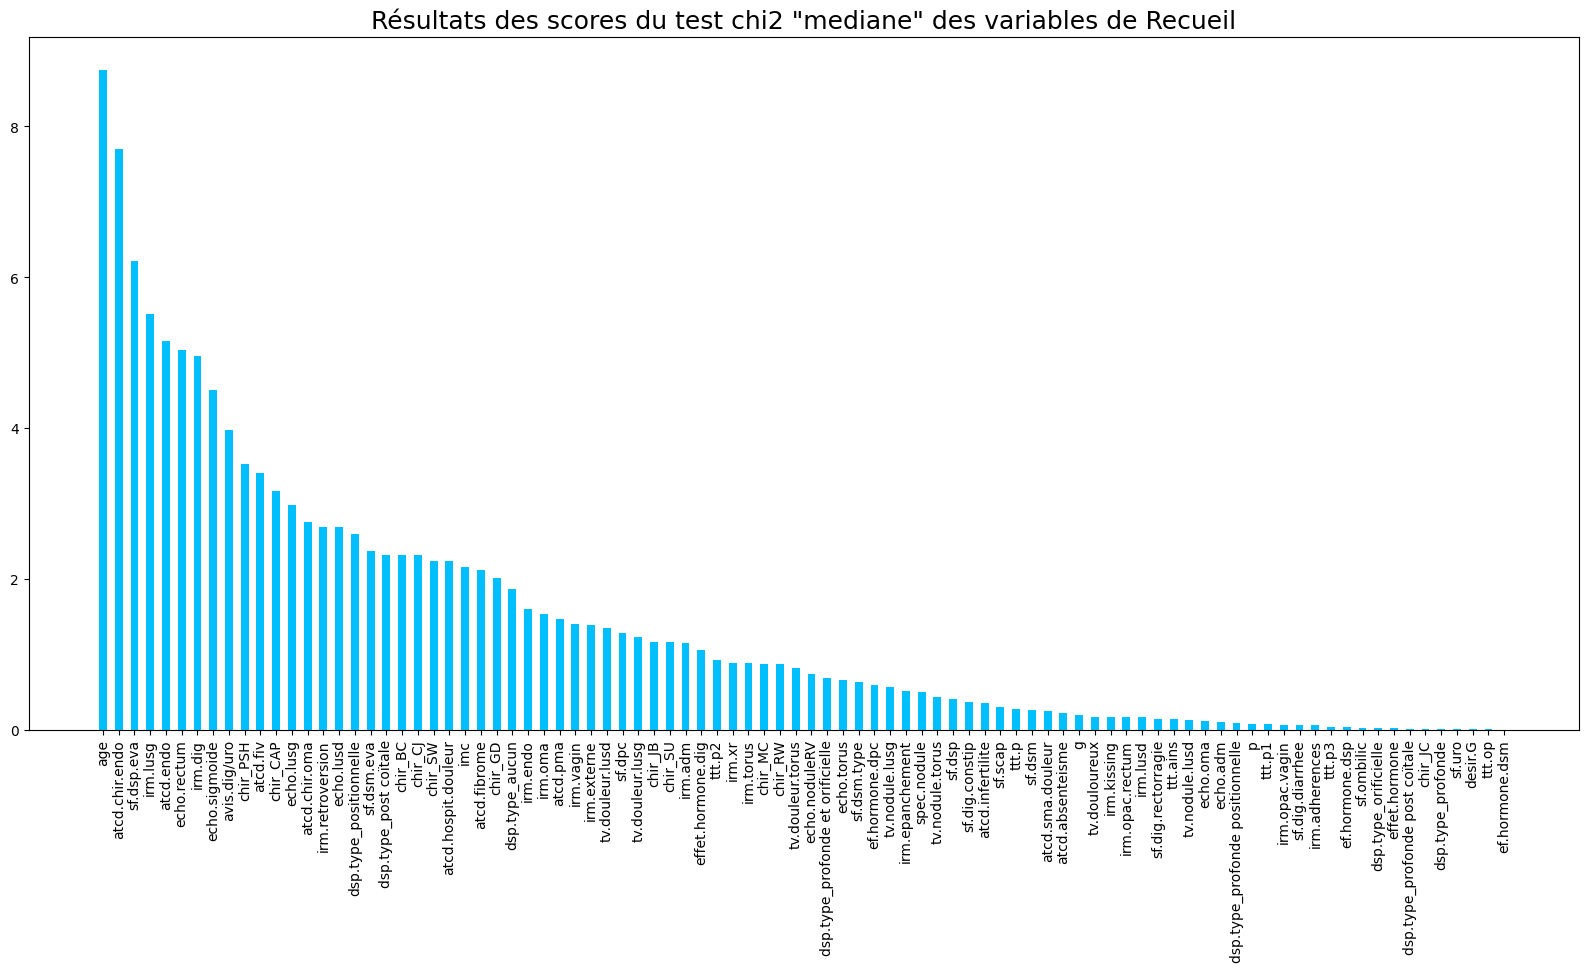

In [46]:
featureScores_chi_med.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du test chi2 "mediane" des variables de Recueil', fontsize=18)
ax.bar(featureScores_chi_med['Features'], height=featureScores_chi_med['Score'], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)


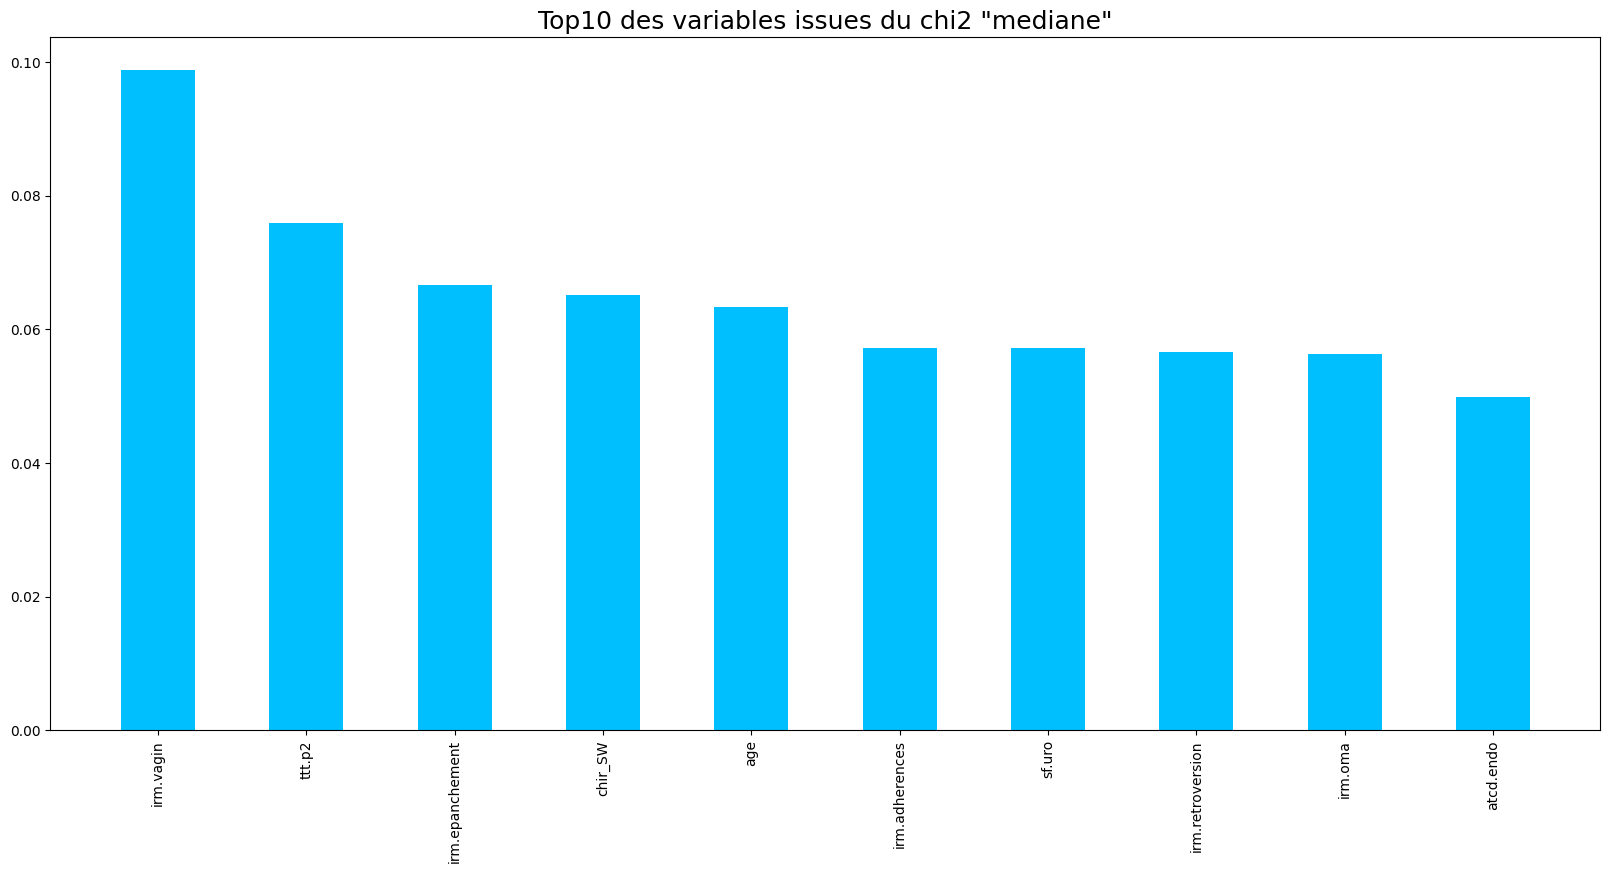

In [47]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues du chi2 "mediane"', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='deepskyblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

In [48]:
df_p_values_chi_med = pd.DataFrame(fit.pvalues_, index=features_enc_mean.columns, columns=['p_value'])
df_p_values_chi_med.sort_values('p_value', ascending=False, inplace=True)
df_p_values_chi_med.iloc[:10,:]

,p_value
age,NaN
imc,NaN
g,NaN
p,NaN
atcd.endo,NaN
atcd.chir.oma,NaN
atcd.fibrome,NaN
atcd.chir.endo,NaN
atcd.infertilite,NaN
atcd.pma,NaN


In [49]:
df_p_values_chi_med.sort_values('p_value', inplace=True)
df_p_values_chi_med.loc[df_p_values_chi_med.loc[:,'p_value']<=0.05]

,p_value


### f_classif test : 

In [50]:
#apply SelectKBest class to extract top 10 best features
bestfeatures_f_med = SelectKBest(score_func=f_classif, k=20)
fit_f_med = bestfeatures_f_med.fit(features_enc_median, endometriose)
dfscores_f_med = pd.DataFrame(fit_f_med.scores_)
pval_f_med = pd.DataFrame(fit_f_med.pvalues_)
dfcolumns_f_med = pd.DataFrame(features_enc_median.columns)
#concat two dataframes for better visualization 
featureScores_f_med = pd.concat([dfcolumns_f_med,dfscores_f_med, pval_f_med],axis=1)
featureScores_f_med.columns = ['Features','Score', 'p values']  #naming the dataframe columns
print(featureScores_f_med.nlargest(10,'Score'))  #print 20 best features

          Features      Score  p values
7   atcd.chir.endo  11.863638  0.000713
4        atcd.endo   9.626426  0.002229
57        irm.lusg   8.398243  0.004225
0              age   6.477023  0.011772
54        irm.endo   6.063025  0.014751
60         irm.dig   5.764629  0.017376
52     echo.rectum   5.525852  0.019826
21          sf.dsm   4.878554  0.028462
53   echo.sigmoide   4.818398  0.029444
70    avis.dig/uro   4.704377  0.031405


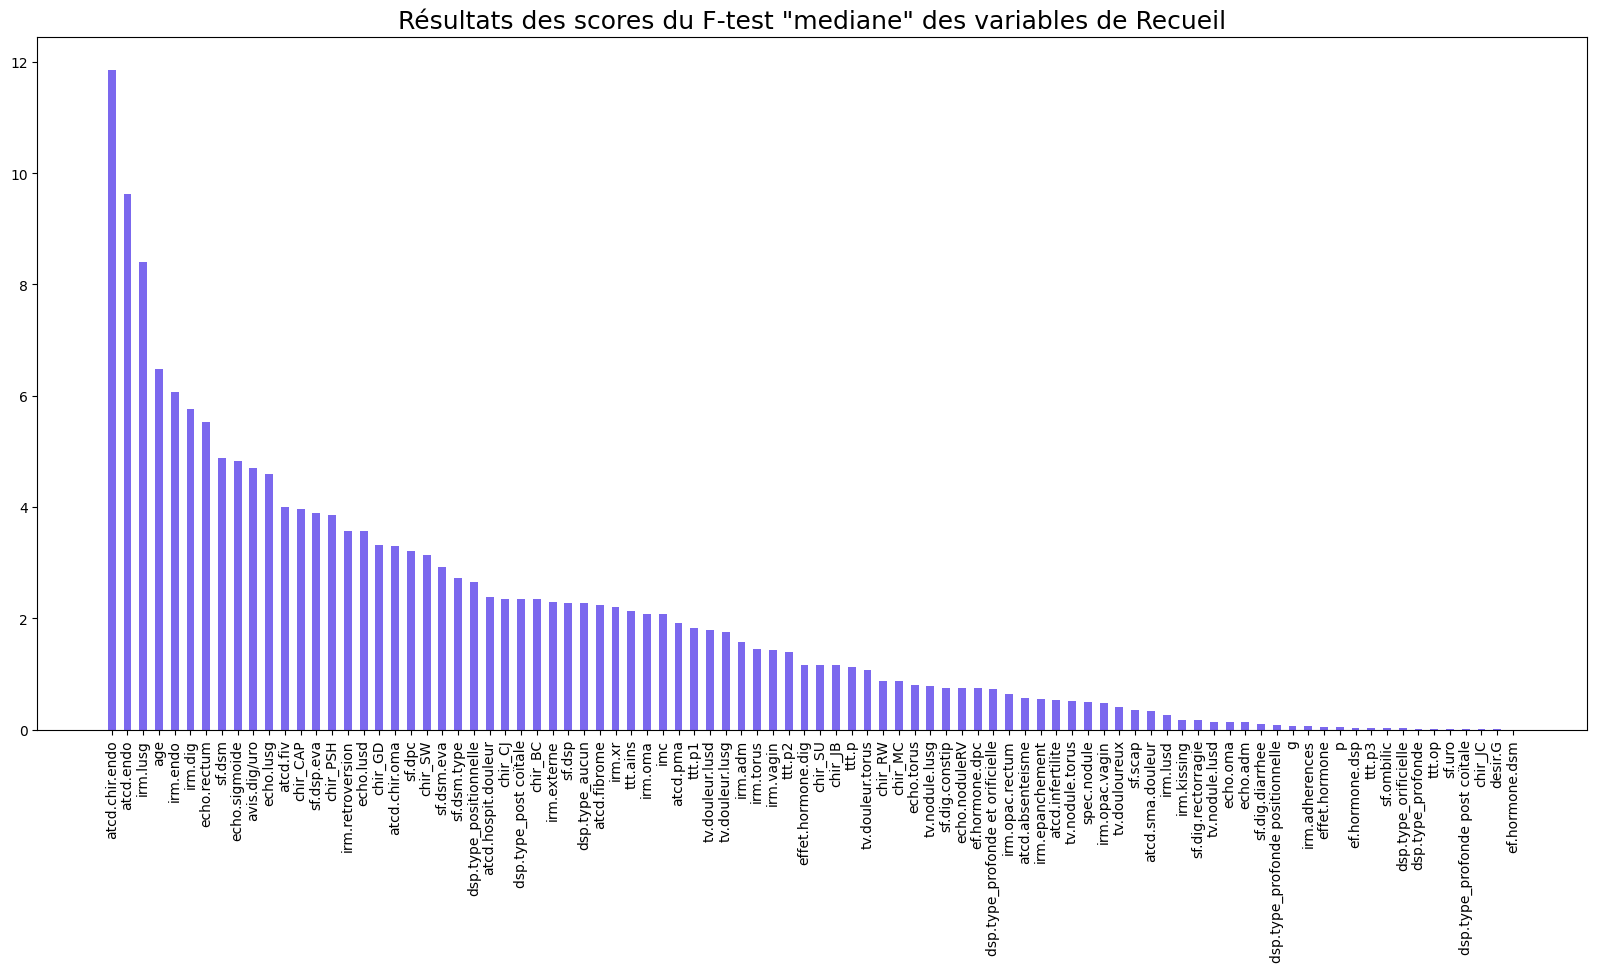

In [51]:
featureScores_f_med.sort_values('Score', inplace=True, ascending=False)


fig, ax = plt.subplots(1,1,figsize=(20, 9))


ax.set_title('Résultats des scores du F-test "mediane" des variables de Recueil', fontsize=18)
ax.bar(featureScores_f_med['Features'], height=featureScores_f_med['Score'], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)



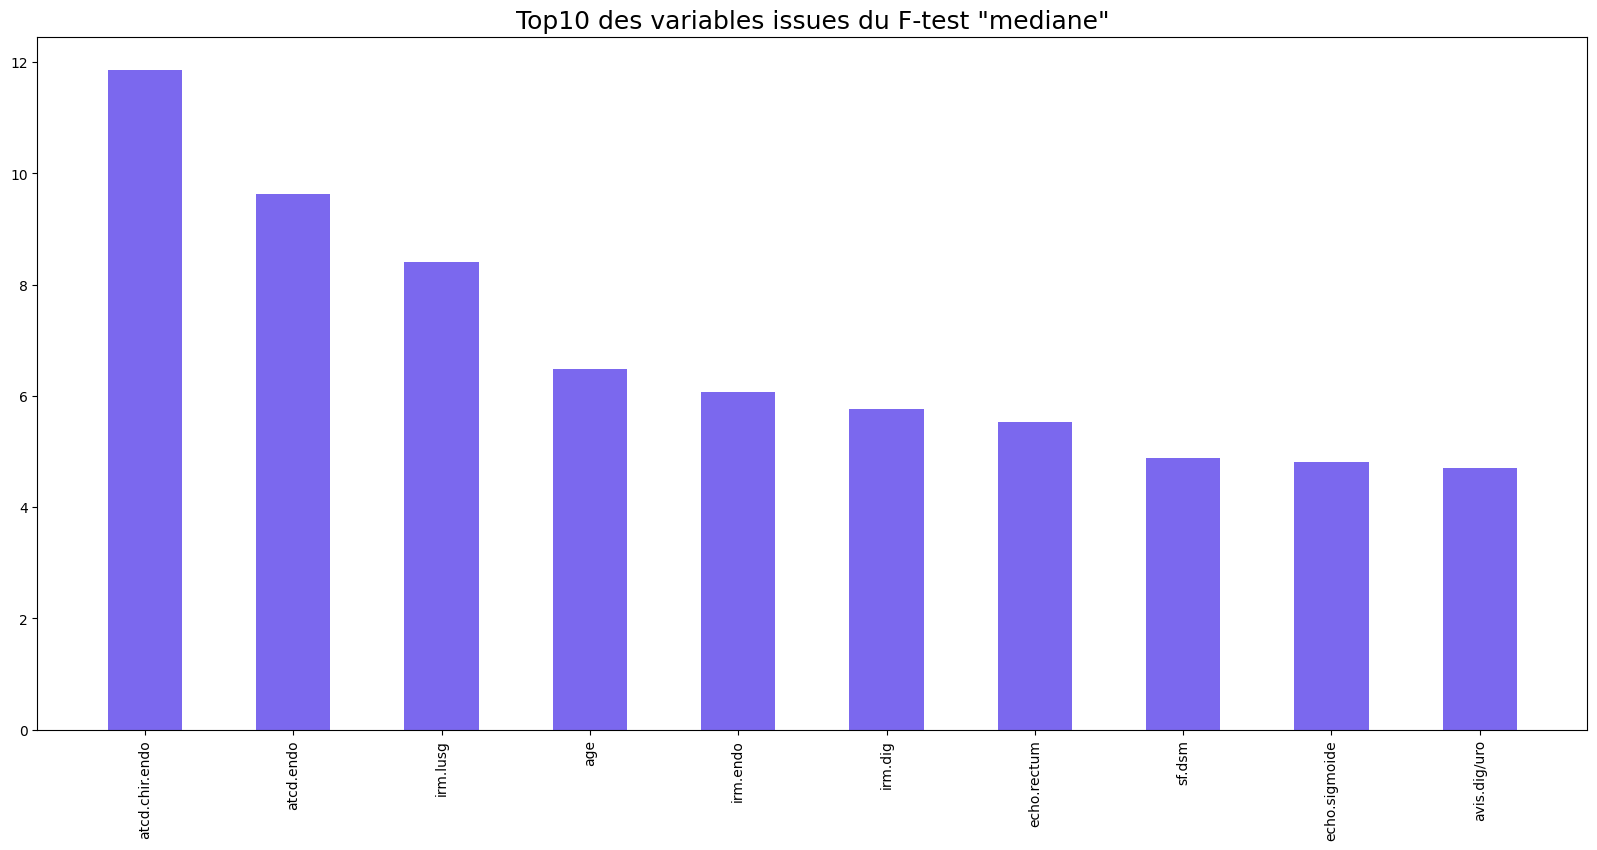

In [52]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues du F-test "mediane"', fontsize=18)
ax.bar(featureScores_f_med['Features'].iloc[:10], height=featureScores_f_med['Score'].iloc[:10], width=0.5, color='mediumslateblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

In [53]:
df_p_values_f_med = pd.DataFrame(fit.pvalues_, index=features_enc_mean.columns, columns=['p_value'])
df_p_values_f_med.sort_values('p_value', inplace=True)

In [54]:
df_p_values_f_med.loc[df_p_values_f_med.loc[:,'p_value']<=0.05]

,p_value


### mutual_info_classif test : 

In [55]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=20)
fit = bestfeatures.fit(features_enc_median, endometriose)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features_enc_mean.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

            Features     Score
49         echo.lusd  0.087656
51        echo.torus  0.068682
41  tv.douleur.torus  0.065644
19            ttt.p2  0.061659
38     tv.douloureux  0.061460
18            ttt.p1  0.057662
72          chir_CAP  0.050869
80           chir_SU  0.047832
0                age  0.045163
76           chir_JC  0.045052
42    tv.nodule.lusd  0.042857
53     echo.sigmoide  0.042389
22       sf.dsm.type  0.041584
52       echo.rectum  0.039731
15            ttt.op  0.039070
10          atcd.fiv  0.038603
3                  p  0.037567
66    irm.opac.vagin  0.034172
23        sf.dsm.eva  0.033084
36    ef.hormone.dpc  0.033084


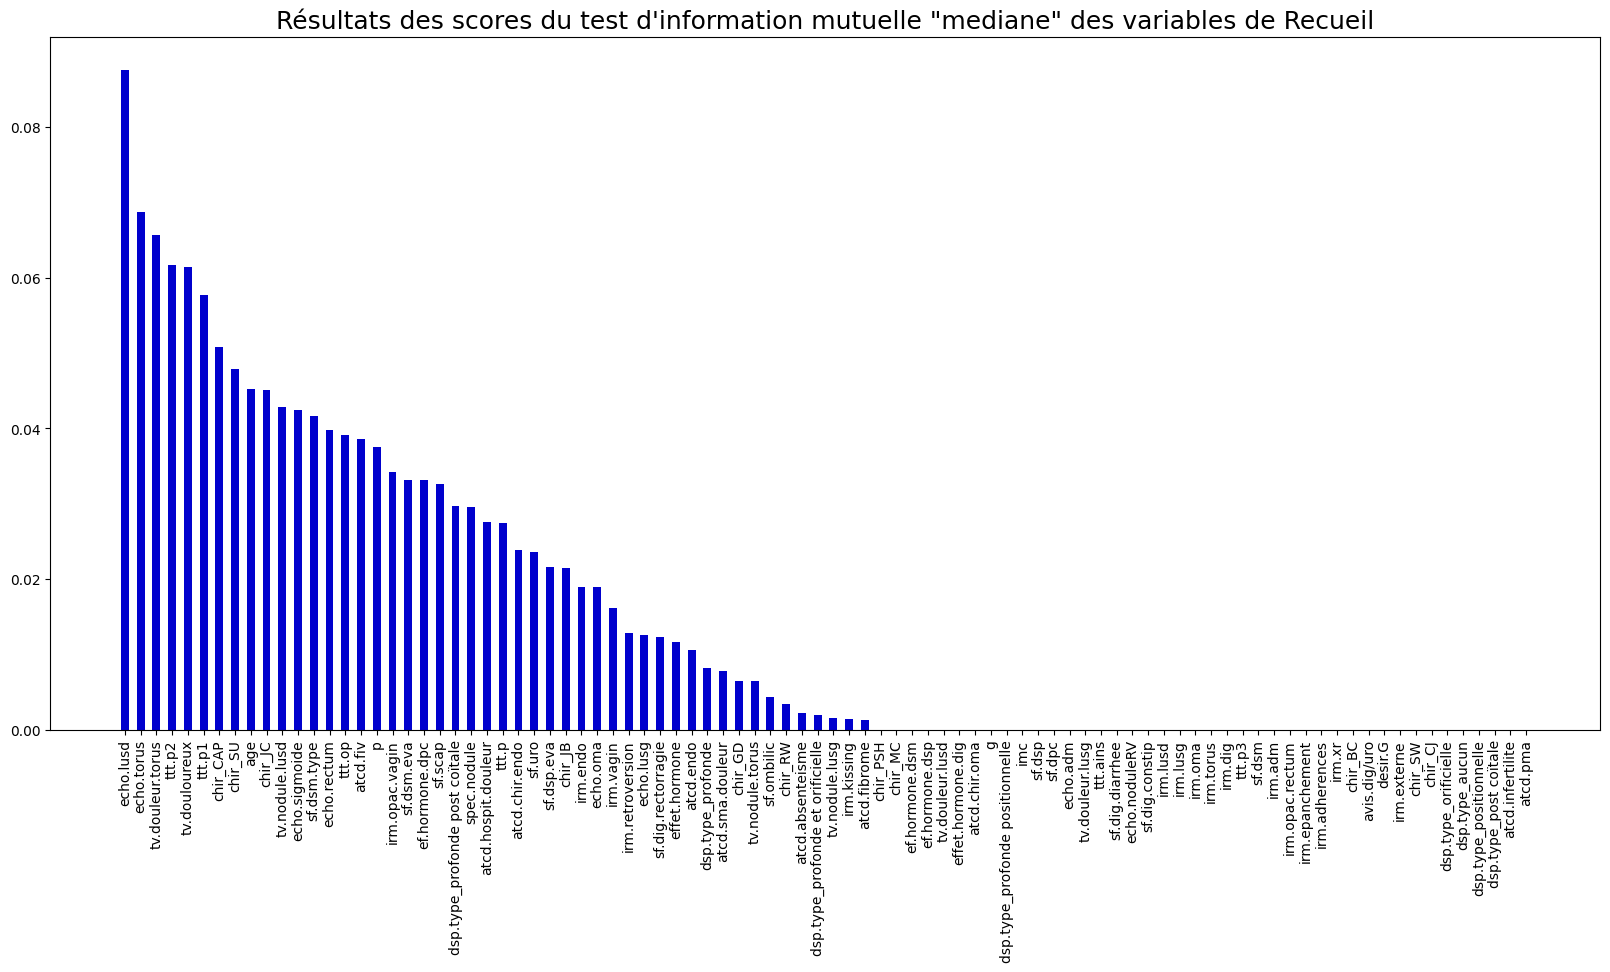

In [56]:
featureScores.sort_values('Score', inplace=True, ascending=False)

fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Résultats des scores du test d\'information mutuelle "mediane" des variables de Recueil', fontsize=18)
ax.bar(featureScores['Features'], height=featureScores['Score'], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)

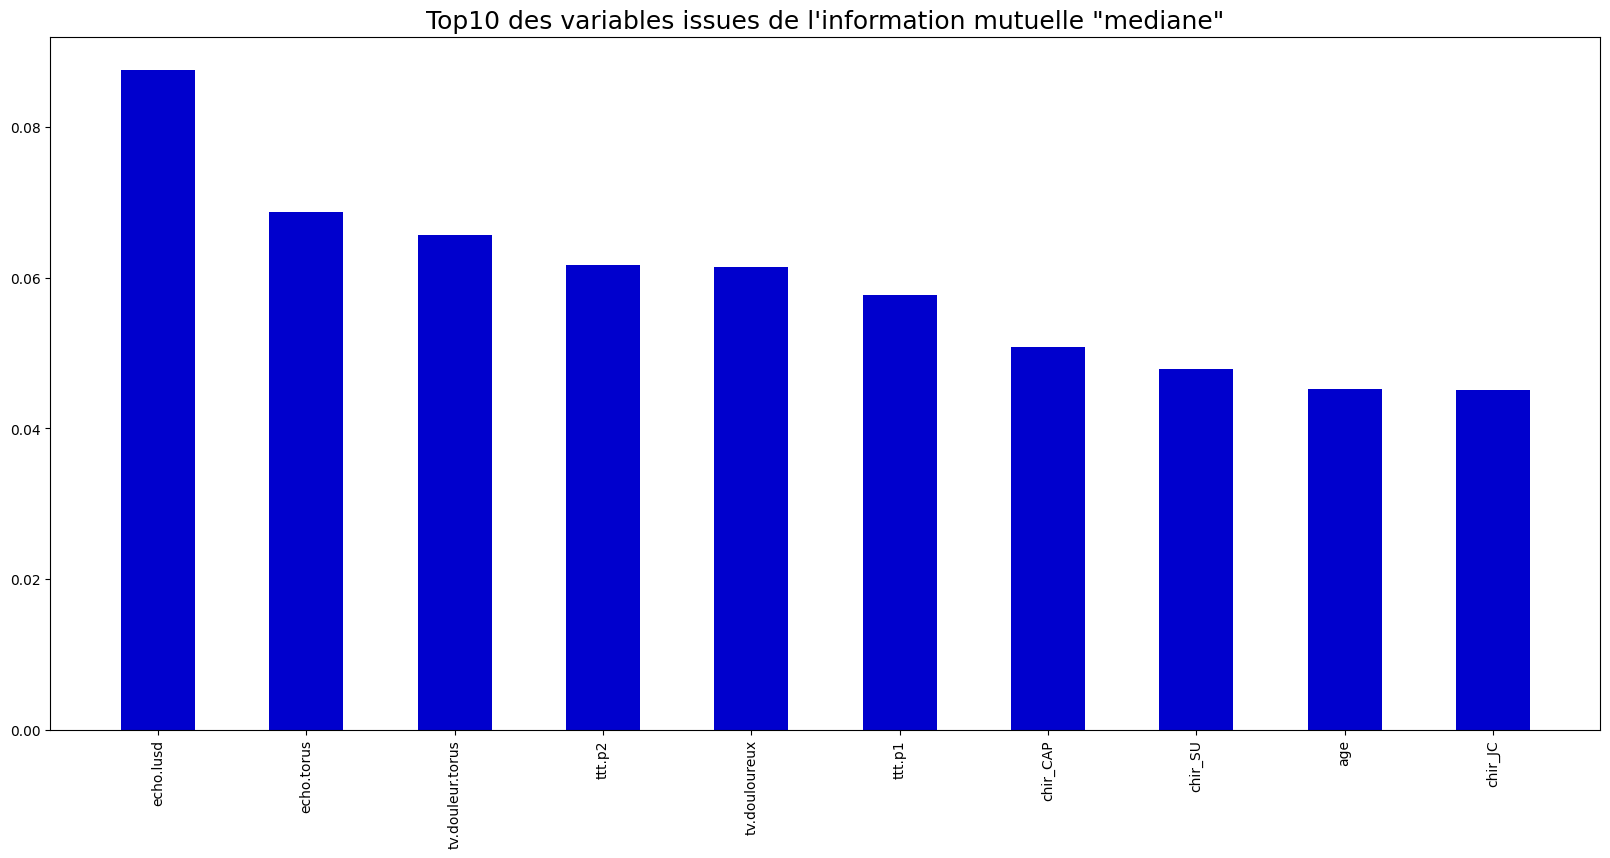

In [57]:
fig, ax = plt.subplots(1,1,figsize=(20, 9))
ax.set_title('Top10 des variables issues de l\'information mutuelle "mediane"', fontsize=18)
ax.bar(featureScores['Features'].iloc[:10], height=featureScores['Score'].iloc[:10], width=0.5, color='mediumblue')
# ax.set_ylim(0,1)
ax.tick_params(axis='x',rotation=90)